목적: KBO 승부예측 모델 만들기

데이터 적용 방법:
- 시계열 데이터기반
- 팀 데이터에서 예측한 연도별 팀승률, 홈승률, 원정승률, 그리고 각 팀간의 상대승률을 추가함
- 선수 데이터에서 얻은 연도,팀별 투수, 타자를 매칭시켜서 주요지표들을 추가함
- 2020~2022년 데이터는 train, 2023년 4월, 1달간의 데이터는 valid, 그리고 2023년 예측을 test셋으로 지정함

추가한 데이터를 주요 피쳐로 사용하여 2023년 KBO 승부예측 모델을 만듦

결론: 'score'를 target으로 득실차를 계산하여서 경기당 승,무,패를 예측하는 모델을 완성했다.
    
한계점: 이전 날짜 데이터들은 선발라인업이 모두 나와있기 때문에 선수의 데이터에 맞춰서 넣으면 꽤 정확한 예측을 할 수 있었지만, 2023년 5월 이후의 데이터는 2023년 4월의 타순과 선발타자의 로테이션을 생각해서 가상으로 넣었기 때문에 정확한 예측은 할 수 없었다.(하지만 바로 경기 전날 라인업을 보고 선수데이터를 넣으면 성능향상을 할 수 있다.)
    

# 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

In [2]:
# 2020~2022년 데이터
train = pd.read_csv('data/pred_train.csv')
print(train.shape)
train.head(3)

(4784, 47)


,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_LI,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP
0,2020-05-05,잠실,두산,34,30,2,6,1,2,3,...,0.5,-0.102,-3.56,72.0,24.0,13.0,0.0,0.0,0.0,0.0
1,2020-05-05,잠실,LG,36,30,8,10,1,6,5,...,0.9,0.398,2.99,81.0,27.0,9.0,0.0,0.0,0.0,0.0
2,2020-05-05,인천문학,한화,35,31,3,8,0,3,2,...,0.8,0.536,4.99,81.0,27.0,5.0,0.0,0.0,0.0,0.0


In [3]:
train.columns

Index(['날짜', '구장', '팀', 'hit_TPA', 'hit_AB', 'hit_R', 'hit_H', 'hit_HR',
       'hit_RBI', 'hit_BB', 'hit_HBP', 'hit_SO', 'hit_GO', 'hit_FO', 'hit_PIT',
       'hit_GDP', 'hit_LOB', 'hit_AVG', 'hit_OPS', 'hit_LI', 'hit_WPA',
       'hit_RE24', 'pitch_IP', 'pitch_TBF', 'pitch_H', 'pitch_R', 'pitch_ER',
       'pitch_BB', 'pitch_HBP', 'pitch_K', 'pitch_HR', 'pitch_GO-FO',
       'pitch_PIT-S', 'pitch_IR-IS', 'pitch_GSC', 'pitch_ERA', 'pitch_WHIP',
       'pitch_LI', 'pitch_WPA', 'pitch_RE24', 'def_IP', 'def_PO', 'def_A',
       'def_E', 'def__P', 'def__A', 'def_GDP'],
      dtype='object')

In [4]:
# 2023년 4월
valid = pd.read_csv('data/pred_valid.csv')
print(valid.shape)
valid.head()

(260, 47)


,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_LI,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP
0,2023-04-01,잠실,롯데,59.0,47.0,10.0,14.0,1.0,10.0,10.0,...,1.3,-1.256,-6.45,90.0,30.0,11.0,1.0,0.0,1.0,0.0
1,2023-04-01,잠실,두산,48.0,38.0,12.0,12.0,2.0,11.0,5.0,...,1.7,-0.757,-3.90,99.0,33.0,9.0,2.0,2.0,0.0,0.0
2,2023-04-01,고척돔,한화,42.0,39.0,2.0,8.0,0.0,1.0,3.0,...,1.6,-0.060,1.73,87.0,29.0,8.0,1.0,1.0,0.0,0.0
3,2023-04-01,고척돔,키움,42.0,40.0,3.0,11.0,0.0,3.0,1.0,...,1.7,0.440,3.55,90.0,30.0,6.0,3.0,3.0,0.0,0.0
4,2023-04-01,인천SSG랜더스,KIA,38.0,31.0,1.0,6.0,0.0,1.0,5.0,...,0.9,-0.032,0.44,72.0,24.0,10.0,1.0,1.0,0.0,0.0


In [5]:
# result는 팀데이터 예측으로 얻은 2020,2021,2022년 팀 승률을 포함한 데이터

result = pd.read_csv('data/팀성적_1차.csv')
re_20 = result[30:40]
re_21 = result[40:50]
re_22 = result[50:60]
re_22

,Unnamed: 0,순_투,G_타,타석_타,타수_타,득점_타,안타_타,2타_타,3타_타,홈런_타,...,팀명_KIA,팀명_KT,팀명_LG,팀명_NC,팀명_SSG,팀명_두산,팀명_롯데,팀명_삼성,팀명_키움,팀명_한화
50,50,1.0,1736.0,5627.0,4927.0,715.0,1325.0,208.0,33.0,118.0,...,0,0,1,0,0,0,0,0,0,0
51,51,2.0,1747.0,5703.0,5001.0,720.0,1362.0,250.0,19.0,113.0,...,1,0,0,0,0,0,0,0,0,0
52,52,3.0,1860.0,5642.0,4893.0,720.0,1245.0,243.0,18.0,138.0,...,0,0,0,0,1,0,0,0,0,0
53,53,4.0,1744.0,5655.0,4953.0,621.0,1249.0,203.0,33.0,94.0,...,0,0,0,0,0,0,0,0,1,0
54,54,5.0,1769.0,5585.0,4899.0,646.0,1261.0,231.0,14.0,105.0,...,0,0,0,1,0,0,0,0,0,0
55,55,6.0,1819.0,5647.0,5023.0,663.0,1357.0,241.0,19.0,103.0,...,0,0,0,0,0,0,0,1,0,0
56,56,7.0,1889.0,5547.0,4864.0,631.0,1237.0,191.0,19.0,119.0,...,0,1,0,0,0,0,0,0,0,0
57,57,8.0,1903.0,5510.0,4892.0,638.0,1249.0,210.0,12.0,101.0,...,0,0,0,0,0,1,0,0,0,0
58,58,9.0,1761.0,5534.0,4948.0,605.0,1320.0,227.0,16.0,106.0,...,0,0,0,0,0,0,1,0,0,0
59,59,10.0,1614.0,5513.0,4877.0,564.0,1197.0,217.0,19.0,88.0,...,0,0,0,0,0,0,0,0,0,1


# 데이터 전처리 및 나머지 데이터 추가

## 팀승률 예측데이터(re_) 전처리

In [6]:
# re_20 데이터에서 '팀'이라는 컬럼을 생성하고 팀순위대로 넣어주기
# 데이터를 가져올때 '순_투'순으로 정렬됐는데 나는 전체 순위로 정렬을 했기 때문에
# 나중에 데이터가 안맞는 사태가 일어났다 (최소 20시간을 헤맸다..) => 꼭 다시 확인하기
re_20['팀'] = ['NC', '두산', 'LG', 'KT', '키움', '롯데', 'KIA', '삼성', 'SSG', '한화']
re_21['팀'] = ['SSG', '두산', '롯데', 'NC', 'KT', '키움', '삼성', 'LG', '한화', 'KIA']
re_22['팀'] = ['LG', 'KIA', 'SSG', '키움', 'NC', '삼성', 'KT', '두산', '롯데', '한화']

lst = ['팀', '승률', '홈_승률', '방문_승률', 'vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률',
       'vs_NC_승률', 'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률', 'vs_KT_승률']
l_20 = re_20[lst]
l_21 = re_21[lst]
l_22 = re_22[lst]
l_20.loc[l_20['팀'] == 'SK', '팀'] = 'SSG'

C:\Users\신하진\AppData\Local\Temp\ipykernel_21852\1234041273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re_20['팀'] = ['NC', '두산', 'LG', 'KT', '키움', '롯데', 'KIA', '삼성', 'SSG', '한화']
C:\Users\신하진\AppData\Local\Temp\ipykernel_21852\1234041273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re_21['팀'] = ['SSG', '두산', '롯데', 'NC', 'KT', '키움', '삼성', 'LG', '한화', 'KIA']
C:\Users\신하진\AppData\Local\Temp\ipykernel_21852\1234041273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

## 2023년 팀 승률 예측(add) 추가

In [7]:
# add는 팀 데이터를 통해 2023년 팀 승률을 예측한것

add = pd.read_csv('data/add.csv')
add.rename(columns={'팀명':'팀'}, inplace=True)
# 원정승률, 홈승률, 상대승률을 추가할수있음 일단 아이디어만 제시
add

,Unnamed: 0,승률,홈_승률,원정_승률,팀
0,0,0.478408,0.512496,0.444009,LG
1,1,0.500168,0.539609,0.459993,NC
2,2,0.500168,0.539609,0.459993,키움
3,3,0.512568,0.555408,0.469117,SSG
4,4,0.484518,0.536404,0.431261,KT
5,5,0.486618,0.527364,0.445118,두산
6,6,0.484235,0.542664,0.424538,롯데
7,7,0.462185,0.514777,0.408340,삼성
8,8,0.492268,0.546932,0.436743,KIA
9,9,0.449312,0.504139,0.393072,한화


## test셋 데이터 추가 및 전처리

In [8]:
# 2023년 5월~ 마지막 경기
test = pd.read_csv('data/pred_test.csv')
print(test.shape)
test['Location'].unique()

# train,test 와 동일하게 구장명 변경
#'울산' => KIA구장, '포항'=> 한화구장
test['Location'] = test['Location'].replace({'문학': '인천SSG랜더스', 
                                             '대구': '라이온즈파크', 
                                             '창원': '창원NC파크', 
                                             '광주': '챔피언스필드', 
                                             '사직': '부산사직', 
                                             '고척': '고척돔', 
                                             '대전': '대전한밭', 
                                             '수원': '케이티위즈파크', 
                                             '울산': '챔피언스필드', 
                                             '포항': '대전한밭'})

(540, 4)


In [9]:
test['Date'] = test['Date'].apply(pd.to_datetime)

In [10]:
print(test.shape)
test.head(10)

(540, 4)


,Date,Team1,Team2,Location
0,2023-05-02,한화,두산,잠실
1,2023-05-02,KT,SSG,인천SSG랜더스
2,2023-05-02,키움,삼성,라이온즈파크
3,2023-05-02,LG,NC,창원NC파크
4,2023-05-02,롯데,KIA,챔피언스필드
5,2023-05-03,한화,두산,잠실
6,2023-05-03,KT,SSG,인천SSG랜더스
7,2023-05-03,키움,삼성,라이온즈파크
8,2023-05-03,LG,NC,창원NC파크
9,2023-05-03,롯데,KIA,챔피언스필드


In [11]:
test[test['Date'] == '2023-05-02']

,Date,Team1,Team2,Location
0,2023-05-02,한화,두산,잠실
1,2023-05-02,KT,SSG,인천SSG랜더스
2,2023-05-02,키움,삼성,라이온즈파크
3,2023-05-02,LG,NC,창원NC파크
4,2023-05-02,롯데,KIA,챔피언스필드
80,2023-05-02,한화,LG,잠실
81,2023-05-02,SSG,롯데,부산사직
82,2023-05-02,삼성,NC,창원NC파크
83,2023-05-02,두산,KT,케이티위즈파크
84,2023-05-02,키움,KIA,챔피언스필드


In [12]:
# train ,test 셋하고 같은 방식으로 바꿔줌

# 새로운 데이터프레임 생성
new_t = pd.DataFrame(columns=['Date', 'Team', 'Location'])

for idx, row in test.iterrows():
    # 팀1과 팀2를 리스트로 묶어서 순회
    for team in [row['Team1'], row['Team2']]:
        # 해당 팀의 정보와 위치 정보를 담는 시리즈 생성
        new_row = pd.Series([row['Date'], team, row['Location']], index=new_t.columns)
        # 시리즈를 새로운 데이터프레임에 추가
        new_t = pd.concat([new_t, new_row.to_frame().T], ignore_index=True)
print(new_t.shape)
new_t

(1080, 3)


,Date,Team,Location
0,2023-05-02,한화,잠실
1,2023-05-02,두산,잠실
2,2023-05-02,KT,인천SSG랜더스
3,2023-05-02,SSG,인천SSG랜더스
4,2023-05-02,키움,라이온즈파크
...,...,...,...
1075,2023-09-01,KT,케이티위즈파크
1076,2023-09-01,LG,챔피언스필드
1077,2023-09-01,KIA,챔피언스필드
1078,2023-09-01,한화,고척돔


In [13]:
# 데이터 크롤링이 제대로 안되서 한 날짜에 20경기씩 잡힌것들이 있었다..
# 이것들을 다 찾아서 원래 날짜로 돌려주려고 한다.
new_t[new_t['Date'] == '2023-05-02']

,Date,Team,Location
0,2023-05-02,한화,잠실
1,2023-05-02,두산,잠실
2,2023-05-02,KT,인천SSG랜더스
3,2023-05-02,SSG,인천SSG랜더스
4,2023-05-02,키움,라이온즈파크
5,2023-05-02,삼성,라이온즈파크
6,2023-05-02,LG,창원NC파크
7,2023-05-02,NC,창원NC파크
8,2023-05-02,롯데,챔피언스필드
9,2023-05-02,KIA,챔피언스필드


In [14]:
new_t['Date']

0      2023-05-02
1      2023-05-02
2      2023-05-02
3      2023-05-02
4      2023-05-02
          ...    
1075   2023-09-01
1076   2023-09-01
1077   2023-09-01
1078   2023-09-01
1079   2023-09-01
Name: Date, Length: 1080, dtype: datetime64[ns]

In [15]:
# 경기가 20개씩 잡혀있는 날짜를 찾았다.
new_t.groupby('Date').size()[new_t.groupby('Date').size() == 20]

Date
2023-05-02    20
2023-05-03    20
2023-06-01    20
2023-06-02    20
2023-06-03    20
2023-08-01    20
2023-08-02    20
2023-08-03    20
2023-09-01    20
dtype: int64

In [16]:
# 실제 일정과 맞춰서 직접 변환해준다.
new_t[new_t['Date'] == '2023-05-02']
new_t.loc[160:169, 'Date'] = '2023-05-20' 

In [17]:
new_t[new_t['Date'] == '2023-05-03']
new_t.loc[240:249, 'Date'] = '2023-05-30' 

In [18]:
new_t[new_t['Date'] == '2023-06-01']
new_t.loc[340:349, 'Date'] = '2023-06-10' 

In [19]:
new_t[new_t['Date'] == '2023-06-02']
new_t.loc[420:429, 'Date'] = '2023-06-20' 

In [20]:
new_t[new_t['Date'] == '2023-06-03']
new_t.loc[510:519, 'Date'] = '2023-06-30' 

In [21]:
new_t[new_t['Date'] == '2023-08-01']
new_t.loc[800:809, 'Date'] = '2023-08-10' 

In [22]:
new_t[new_t['Date'] == '2023-08-02']
new_t.loc[890:899, 'Date'] = '2023-08-20' 

In [23]:
new_t[new_t['Date'] == '2023-08-03']
new_t.loc[970:979, 'Date'] = '2023-08-30' 

In [24]:
new_t[new_t['Date'] == '2023-09-01']
new_t.loc[1070:1079, 'Date'] = '2023-09-10'

In [25]:
test = new_t.copy()
# test = test.sort_values(by=['Date', 'Location'])
test = test.rename(columns={'Date': '날짜', 'Team': '팀', 'Location': '구장'})
test.head(20)

,날짜,팀,구장
0,2023-05-02,한화,잠실
1,2023-05-02,두산,잠실
2,2023-05-02,KT,인천SSG랜더스
3,2023-05-02,SSG,인천SSG랜더스
4,2023-05-02,키움,라이온즈파크
5,2023-05-02,삼성,라이온즈파크
6,2023-05-02,LG,창원NC파크
7,2023-05-02,NC,창원NC파크
8,2023-05-02,롯데,챔피언스필드
9,2023-05-02,KIA,챔피언스필드


## train, valid 셋에 선발투수, 타자 라인업 데이터 추가

In [26]:
line_20 = pd.read_csv('data/lineup/2020.csv')
line_21 = pd.read_csv('data/lineup/2021.csv')
line_22 = pd.read_csv('data/lineup/2022.csv')
line_23 = pd.read_csv('data/lineup/2023-04.csv')
line_20 = line_20.rename(columns={'date': '날짜', 'team': '팀'})
line_21 = line_21.rename(columns={'date': '날짜', 'team': '팀'})
line_22 = line_22.rename(columns={'date': '날짜', 'team': '팀'})
line_23 = line_23.rename(columns={'date': '날짜', 'team': '팀'})

# 2020년만 SK->SSG로 변경
line_20['팀'].replace('SK', 'SSG', inplace=True)
# 데이터프레임들을 리스트로 묶어서 concat 함수에 전달
lineup = pd.concat([line_20, line_21, line_22, line_23], axis=0, ignore_index=True)
# 날짜는 datetime으로 변경(후에 합치기 위해)
lineup['날짜'] = lineup['날짜'].apply(lambda x: pd.to_datetime(x))
lineup

,날짜,팀,1,2,3,4,5,6,7,8,9,선발투수
0,2020-05-05,두산,박건우,허경민,오재일,김재환,페르난데스,김재호,박세혁,오재원,정수빈,알칸타라
1,2020-05-05,LG,이천웅,정근우,김현수,라모스,채은성,박용택,김민성,유강남,오지환,차우찬
2,2020-05-05,한화,이용규,정은원,호잉,이성열,송광민,김태균,정진호,최재훈,하주석,서폴드
3,2020-05-05,SSG,노수광,고종욱,최정,로맥,한유섬,윤석민,이재원,김창평,정현,킹엄
4,2020-05-05,롯데,민병헌,전준우,손아섭,이대호,안치홍,정훈,마차도,한동희,정보근,스트레일리
...,...,...,...,...,...,...,...,...,...,...,...,...
4317,2023-04-30,KT,홍현빈,강백호,알포드,장성우,김준태,황재균,조용호,오윤석,신본기,엄상백
4318,2023-04-30,NC,손아섭,서호철,박민우,김성욱,천재환,박세혁,오영수,김주원,도태훈,페디
4319,2023-04-30,한화,이원석,이진영,노시환,채은성,최재훈,박상언,김태연,유로결,오선진,문동주
4320,2023-04-30,키움,이용규,김혜성,이정후,러셀,이원석,임병욱,이병규,김태진,이지영,안우진


## train, valid 셋 이상치 확인 및 전처리

In [27]:
train.isnull().sum()

날짜               0
구장               0
팀                0
hit_TPA        499
hit_AB         499
hit_R          499
hit_H          499
hit_HR         499
hit_RBI        499
hit_BB         499
hit_HBP        499
hit_SO         499
hit_GO         499
hit_FO         499
hit_PIT        499
hit_GDP        499
hit_LOB        499
hit_AVG        499
hit_OPS        499
hit_LI         499
hit_WPA        499
hit_RE24       499
pitch_IP        80
pitch_TBF      574
pitch_H        574
pitch_R        574
pitch_ER       574
pitch_BB       574
pitch_HBP      574
pitch_K        574
pitch_HR       574
pitch_GO-FO     80
pitch_PIT-S     80
pitch_IR-IS     80
pitch_GSC      576
pitch_ERA      574
pitch_WHIP     574
pitch_LI       574
pitch_WPA      574
pitch_RE24     574
def_IP         124
def_PO         618
def_A          618
def_E          618
def__P         618
def__A         618
def_GDP        618
dtype: int64

In [28]:
train['pitch_GSC']

0       49.0
1       67.0
2       84.0
3       55.0
4       56.0
        ... 
4779     NaN
4780     NaN
4781     NaN
4782     NaN
4783     NaN
Name: pitch_GSC, Length: 4784, dtype: object

In [29]:
# 'pitch_GSC'는 한 투수가 한 경기에서 얼마나 효과적으로 투구를 했는지를 나타내는 지표
# 이후에 한번에 처리함

train[train['pitch_GSC'].isna()]

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_LI,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP
40,2020-05-09,할러웨이,할러웨이,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,2020-05-09,부산사직,SK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
46,2020-05-09,부산사직,롯데,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
47,2020-05-09,창원NC파크,LG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
48,2020-05-09,창원NC파크,NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,2022-11-05,고척돔,키움,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
4780,2022-11-07,인천SSG랜더스,키움,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
4781,2022-11-07,인천SSG랜더스,SSG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN
4782,2022-11-08,인천SSG랜더스,키움,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
valid.isnull().sum()

날짜              0
구장              0
팀               0
hit_TPA        44
hit_AB         44
hit_R          44
hit_H          44
hit_HR         44
hit_RBI        44
hit_BB         44
hit_HBP        44
hit_SO         44
hit_GO         44
hit_FO         44
hit_PIT        44
hit_GDP        44
hit_LOB        44
hit_AVG        44
hit_OPS        44
hit_LI         44
hit_WPA        44
hit_RE24       44
pitch_IP        0
pitch_TBF      44
pitch_H        44
pitch_R        44
pitch_ER       44
pitch_BB       44
pitch_HBP      44
pitch_K        44
pitch_HR       44
pitch_GO-FO     0
pitch_PIT-S     0
pitch_IR-IS     0
pitch_GSC      44
pitch_ERA      44
pitch_WHIP     44
pitch_LI       44
pitch_WPA      44
pitch_RE24     44
def_IP          0
def_PO         44
def_A          44
def_E          44
def__P         44
def__A         44
def_GDP        44
dtype: int64

In [31]:
train['팀'].unique()

array(['두산', 'LG', '한화', 'SK', '롯데', 'KT', 'NC', '삼성', '키움', 'KIA',
       '할러웨이', '잠실', 'SSG', '라이온즈파크', '창원NC파크', '케이티위즈파크'], dtype=object)

In [32]:
train['구장'].unique()

array(['잠실', '인천문학', '케이티위즈파크', '라이온즈파크', '챔피언스필드', '고척돔', '부산사직',
       '창원NC파크', '할러웨이', '대전한밭', '인천SSG랜더스', '14:00', '포항', '울산'],
      dtype=object)

In [33]:
valid['팀'].unique()

array(['롯데', '두산', '한화', '키움', 'KIA', 'SSG', 'LG', 'KT', 'NC', '삼성'],
      dtype=object)

In [34]:
valid['구장'].unique()

array(['잠실', '고척돔', '인천SSG랜더스', '케이티위즈파크', '대구삼성라이온즈', '대전한밭', '챔피언스필드',
       '부산사직', '창원NC파크'], dtype=object)

In [35]:
# '포항'은 삼성 홈경기로 확인
train[train['구장']=='포항']

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_LI,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP
4138,2022-07-26,포항,한화,39.0,35.0,4.0,9.0,0.0,4.0,2.0,...,1.3,0.411,2.99,81.0,27.0,11.0,2.0,0.0,2.0,0.0
4139,2022-07-26,포항,삼성,34.0,32.0,2.0,7.0,0.0,2.0,1.0,...,0.9,-0.089,0.99,81.0,27.0,11.0,0.0,0.0,0.0,0.0
4148,2022-07-27,포항,한화,47.0,40.0,10.0,12.0,1.0,10.0,6.0,...,1.2,-1.026,-6.56,72.0,24.0,5.0,1.0,0.0,1.0,0.0
4149,2022-07-27,포항,삼성,44.0,37.0,11.0,14.0,0.0,10.0,5.0,...,1.2,-0.526,-5.01,81.0,27.0,7.0,1.0,1.0,0.0,0.0
4158,2022-07-28,포항,한화,40.0,39.0,3.0,6.0,1.0,3.0,0.0,...,1.9,0.537,3.66,108.0,36.0,9.0,0.0,0.0,0.0,0.0
4159,2022-07-28,포항,삼성,49.0,44.0,3.0,8.0,0.0,3.0,5.0,...,1.0,0.537,3.66,108.0,36.0,15.0,0.0,0.0,0.0,0.0


In [36]:
# '울산'은 롯데 홈경기로 확인
train[train['구장']=='울산']

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_LI,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP
4486,2022-09-06,울산,KIA,38.0,34.0,3.0,8.0,2.0,3.0,3.0,...,0.9,-0.279,-1.56,72.0,24.0,9.0,2.0,0.0,2.0,0.0
4487,2022-09-06,울산,롯데,35.0,30.0,6.0,9.0,1.0,6.0,4.0,...,1.3,0.221,1.99,81.0,27.0,10.0,1.0,0.0,1.0,0.0
4496,2022-09-07,울산,KIA,44.0,39.0,12.0,15.0,2.0,11.0,4.0,...,0.9,-0.239,-1.00,81.0,27.0,10.0,1.0,1.0,0.0,0.0
4497,2022-09-07,울산,롯데,41.0,35.0,6.0,9.0,2.0,5.0,5.0,...,1.1,-0.739,-7.01,81.0,27.0,10.0,2.0,0.0,2.0,0.0


In [37]:
# 우천취소 등으로 인한 공백칸 제거 1
train = train[train['팀'].isin(('두산', 'LG', '한화', 'SK', '롯데', 'KT', 'NC', '삼성', '키움', 'KIA', 'SSG'))]
valid = valid[valid['팀'].isin(('두산', 'LG', '한화', 'SK', '롯데', 'KT', 'NC', '삼성', '키움', 'KIA', 'SSG'))]
# 우천취소 등으로 인한 공백칸 제거 2
train = train[~train['hit_R'].isna()]
valid = valid[~valid['hit_R'].isna()]

# SK데이터를 SSG데이터로 써야하니까 임의로 SSG로 변경함
train['팀'] = train['팀'].replace('SK', 'SSG')
valid = valid[~valid['hit_R'].isna()]

# 데이터 자체가 없으므로 평균값으로 대체해준다.
train['pitch_GSC'] = pd.to_numeric(train['pitch_GSC'], errors='coerce')
mean_pitch_GSC = train['pitch_GSC'].mean()
train['pitch_GSC'] = train['pitch_GSC'].fillna(mean_pitch_GSC).astype(float)

train['구장'] = train['구장'].replace({'인천문학': '인천SSG랜더스', '포항': '대구삼성라이온즈', '울산': '부산사직'})
valid['구장'] = valid['구장'].replace({'인천문학': '인천SSG랜더스', '포항': '대구삼성라이온즈', '울산': '부산사직'})

In [38]:
# 홈/원정 구분
train['구분'] = train.index.map(lambda x: '홈' if x%2==1 else '원정')
valid['구분'] = valid.index.map(lambda x: '홈' if x%2==1 else '원정')

In [39]:
train.head(2)

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_WPA,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP,구분
0,2020-05-05,잠실,두산,34,30,2,6,1,2,3,...,-0.102,-3.56,72.0,24.0,13.0,0.0,0.0,0.0,0.0,원정
1,2020-05-05,잠실,LG,36,30,8,10,1,6,5,...,0.398,2.99,81.0,27.0,9.0,0.0,0.0,0.0,0.0,홈


In [40]:
# train 데이터를 연도구분해준다.

train['날짜'] = pd.to_datetime(train['날짜'])
train_2020 = train[train['날짜'].dt.year == 2020].copy()
train_2021 = train[train['날짜'].dt.year == 2021].copy()
train_2022 = train[train['날짜'].dt.year == 2022].copy()


## train 셋에 승률데이터 매칭시켜주기

In [41]:
train_2020['승률'] = l_20.set_index('팀').loc[train_2020['팀'], '승률'].values
train_2021['승률'] = l_21.set_index('팀').loc[train_2021['팀'], '승률'].values
train_2022['승률'] = l_22.set_index('팀').loc[train_2022['팀'], '승률'].values

In [42]:
# 홀수번째 팀과 짝수번째 팀의 상대승률을 각각 매핑해준다.

for idx, row in train_2020.iterrows():
    team = row['팀']
    if team in l_20['팀'].values:
        away_win_rate = l_20[l_20['팀']==team]['방문_승률'].values[0]
        home_win_rate = l_20[l_20['팀']==team]['홈_승률'].values[0]
        train_2020.at[idx, '홈/원정_승률'] = home_win_rate if row['구분']=='홈' else away_win_rate

for idx, row in train_2021.iterrows():
    team = row['팀']
    if team in l_21['팀'].values:
        away_win_rate = l_21[l_21['팀']==team]['방문_승률'].values[0]
        home_win_rate = l_21[l_21['팀']==team]['홈_승률'].values[0]
        train_2021.at[idx, '홈/원정_승률'] = home_win_rate if row['구분']=='홈' else away_win_rate

for idx, row in train_2022.iterrows():
    team = row['팀']
    if team in l_22['팀'].values:
        away_win_rate = l_22[l_22['팀']==team]['방문_승률'].values[0]
        home_win_rate = l_22[l_22['팀']==team]['홈_승률'].values[0]
        train_2022.at[idx, '홈/원정_승률'] = home_win_rate if row['구분']=='홈' else away_win_rate

In [43]:
# 팀간의 상대승률 컬럼을 추가해준다
train_2020 = pd.merge(train_2020, l_20[['팀', 'vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                                        'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                                        'vs_KT_승률']], on='팀', how='left')
train_2021 = pd.merge(train_2021, l_21[['팀', 'vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                                        'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                                        'vs_KT_승률']], on='팀', how='left')
train_2022 = pd.merge(train_2022, l_22[['팀', 'vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                                        'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                                        'vs_KT_승률']], on='팀', how='left')

In [44]:
# 상대승률 컬럼 생성
train_2020['상대승률'] = 0

# 각 행마다 상대 팀과의 승률 계산하여 값 할당
for i in range(0, len(train_2020), 2):
    opp_team = train_2020.iloc[i+1]['팀']
    vs_win_rate = train_2020.iloc[i]['vs_' + opp_team + '_승률']
    train_2020.at[i, '상대승률'] = vs_win_rate
    train_2020.at[i+1, '상대승률'] = 1 - vs_win_rate
    
    
# 상대승률 컬럼 생성
train_2021['상대승률'] = 0

# 각 행마다 상대 팀과의 승률 계산하여 값 할당
for i in range(0, len(train_2021), 2):
    opp_team = train_2021.iloc[i+1]['팀']
    vs_win_rate = train_2021.iloc[i]['vs_' + opp_team + '_승률']
    train_2021.at[i, '상대승률'] = vs_win_rate
    train_2021.at[i+1, '상대승률'] = 1 - vs_win_rate


# 상대승률 컬럼 생성
train_2022['상대승률'] = 0

# 각 행마다 상대 팀과의 승률 계산하여 값 할당
for i in range(0, len(train_2022), 2):
    opp_team = train_2022.iloc[i+1]['팀']
    vs_win_rate = train_2022.iloc[i]['vs_' + opp_team + '_승률']
    train_2022.at[i, '상대승률'] = vs_win_rate
    train_2022.at[i+1, '상대승률'] = 1 - vs_win_rate

In [45]:
train_2022

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률,vs_KT_승률,상대승률
0,2022-04-02,잠실,한화,41.0,36.0,4.0,10.0,0.0,4.0,5.0,...,0.437500,0.250000,0.400000,0.375000,0.250000,0.250000,0.5000,0.2000,0.500000,0.437500
1,2022-04-02,잠실,두산,35.0,32.0,6.0,9.0,1.0,6.0,3.0,...,0.500000,0.533333,0.500000,0.266667,0.375000,0.562500,0.5625,0.3125,0.250000,0.562500
2,2022-04-02,창원NC파크,SSG,42.0,36.0,4.0,8.0,0.0,4.0,3.0,...,0.733333,0.666667,0.533333,0.500000,0.533333,0.687500,0.6250,0.6875,0.500000,0.533333
3,2022-04-02,창원NC파크,NC,31.0,30.0,0.0,0.0,0.0,0.0,1.0,...,0.500000,0.500000,0.500000,0.466667,0.375000,0.266667,0.6000,0.6250,0.500000,0.466667
4,2022-04-02,케이티위즈파크,삼성,30.0,29.0,1.0,2.0,0.0,1.0,1.0,...,0.687500,0.533333,0.375000,0.312500,0.250000,0.312500,0.8000,0.5000,0.312500,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,2022-10-19,케이티위즈파크,KT,38.0,37.0,2.0,9.0,0.0,2.0,1.0,...,0.750000,0.562500,0.500000,0.500000,0.437500,0.466667,0.5000,0.6875,0.500000,0.466667
1448,2022-10-20,케이티위즈파크,키움,40.0,35.0,6.0,10.0,1.0,6.0,1.0,...,0.437500,0.625000,0.733333,0.312500,0.375000,0.500000,0.7500,0.6875,0.533333,0.533333
1449,2022-10-20,케이티위즈파크,KT,42.0,36.0,9.0,15.0,1.0,8.0,4.0,...,0.750000,0.562500,0.500000,0.500000,0.437500,0.466667,0.5000,0.6875,0.500000,0.466667
1450,2022-10-22,고척돔,KT,37.0,36.0,3.0,9.0,1.0,3.0,0.0,...,0.750000,0.562500,0.500000,0.500000,0.437500,0.466667,0.5000,0.6875,0.500000,0.466667


In [46]:
# train set으로 합쳐준다
train = pd.concat([train_2020, train_2021, train_2022], axis=0)
vs_team = ['vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                    'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                    'vs_KT_승률']
train = train.drop(vs_team, axis=1)
train.tail()

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,def_PO,def_A,def_E,def__P,def__A,def_GDP,구분,승률,홈/원정_승률,상대승률
1447,2022-10-19,케이티위즈파크,KT,38.0,37.0,2.0,9.0,0.0,2.0,1.0,...,27.0,9.0,1.0,1.0,0.0,0.0,홈,0.563,0.563380,0.466667
1448,2022-10-20,케이티위즈파크,키움,40.0,35.0,6.0,10.0,1.0,6.0,1.0,...,24.0,8.0,1.0,0.0,1.0,0.0,원정,0.563,0.577465,0.533333
1449,2022-10-20,케이티위즈파크,KT,42.0,36.0,9.0,15.0,1.0,8.0,4.0,...,27.0,9.0,2.0,1.0,1.0,0.0,홈,0.563,0.563380,0.466667
1450,2022-10-22,고척돔,KT,37.0,36.0,3.0,9.0,1.0,3.0,0.0,...,24.0,7.0,0.0,0.0,0.0,0.0,원정,0.563,0.563380,0.466667
1451,2022-10-22,고척돔,키움,34.0,31.0,4.0,9.0,1.0,3.0,3.0,...,27.0,10.0,1.0,1.0,0.0,0.0,홈,0.563,0.549296,0.533333


In [47]:
# valid 데이터프레임과 add 데이터프레임을 '팀' 컬럼을 기준으로 합칩니다.
valid_add = pd.merge(valid, add[['팀', '승률']], on='팀', how='left')

# 합친 데이터프레임을 출력합니다.
valid_add.head(2)

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,pitch_RE24,def_IP,def_PO,def_A,def_E,def__P,def__A,def_GDP,구분,승률
0,2023-04-01,잠실,롯데,59.0,47.0,10.0,14.0,1.0,10.0,10.0,...,-6.45,90.0,30.0,11.0,1.0,0.0,1.0,0.0,원정,0.484235
1,2023-04-01,잠실,두산,48.0,38.0,12.0,12.0,2.0,11.0,5.0,...,-3.90,99.0,33.0,9.0,2.0,2.0,0.0,0.0,홈,0.486618


In [48]:
# add 데이터프레임에서 '팀', '홈_승률', '원정_승률' 컬럼만 선택합니다.
add_team_win_rates = add[['팀', '홈_승률', '원정_승률']]

# merged_df 데이터프레임과 add_team_win_rates 데이터프레임을 '팀' 컬럼을 기준으로 합칩니다.
df_1 = pd.merge(valid_add, add_team_win_rates, on='팀', how='left')

# '홈/원정_승률' 컬럼에 값을 추가합니다.
df_1.loc[df_1['구분'] == '홈', '홈/원정_승률'] = df_1['홈_승률']
df_1.loc[df_1['구분'] == '원정', '홈/원정_승률'] = df_1['원정_승률']

# 결과를 출력합니다.
df_1

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,def_A,def_E,def__P,def__A,def_GDP,구분,승률,홈_승률,원정_승률,홈/원정_승률
0,2023-04-01,잠실,롯데,59.0,47.0,10.0,14.0,1.0,10.0,10.0,...,11.0,1.0,0.0,1.0,0.0,원정,0.484235,0.542664,0.424538,0.424538
1,2023-04-01,잠실,두산,48.0,38.0,12.0,12.0,2.0,11.0,5.0,...,9.0,2.0,2.0,0.0,0.0,홈,0.486618,0.527364,0.445118,0.527364
2,2023-04-01,고척돔,한화,42.0,39.0,2.0,8.0,0.0,1.0,3.0,...,8.0,1.0,1.0,0.0,0.0,원정,0.449312,0.504139,0.393072,0.393072
3,2023-04-01,고척돔,키움,42.0,40.0,3.0,11.0,0.0,3.0,1.0,...,6.0,3.0,3.0,0.0,0.0,홈,0.500168,0.539609,0.459993,0.539609
4,2023-04-01,인천SSG랜더스,KIA,38.0,31.0,1.0,6.0,0.0,1.0,5.0,...,10.0,1.0,1.0,0.0,0.0,원정,0.492268,0.546932,0.436743,0.436743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2023-04-30,케이티위즈파크,KT,44.0,35.0,0.0,5.0,0.0,0.0,8.0,...,10.0,0.0,0.0,0.0,0.0,홈,0.484518,0.536404,0.431261,0.536404
212,2023-04-30,대전한밭,NC,35.0,30.0,4.0,8.0,0.0,3.0,3.0,...,10.0,1.0,1.0,0.0,0.0,원정,0.500168,0.539609,0.459993,0.459993
213,2023-04-30,대전한밭,한화,33.0,29.0,1.0,2.0,0.0,1.0,3.0,...,13.0,0.0,0.0,0.0,0.0,홈,0.449312,0.504139,0.393072,0.504139
214,2023-04-30,부산사직,키움,39.0,36.0,3.0,9.0,0.0,3.0,2.0,...,12.0,1.0,1.0,0.0,0.0,원정,0.500168,0.539609,0.459993,0.459993


## 팀 데이터로 얻은 예측값 데이터프레임 만들기

In [49]:
# 팀 데이터에서 가져온 예측값으로 데이터프레임을 만든다
# 가장 최근 예측한 값중 점수가 잘나온 데이터를 가져옴

team_name = ['LG', 'NC','키움', 'SSG', 'KT', '두산', '롯데', '삼성', 'KIA', '한화']

target_columns = ['vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률',
                  'vs_NC_승률', 'vs_SSG_승률'
                  , 'vs_LG_승률', 'vs_KT_승률',
                  'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률']

array = np.array([[0.42387355, 0.54601349, 0.5213283 , 0.48599431, 0.4826833 ,
        0.4656512 , 0.48468705, 0.44180298, 0.58946957, 0.52210385],
       [0.43102615, 0.54503904, 0.51560636, 0.46878498, 0.4614867 ,
        0.45035833, 0.47403802, 0.43852831, 0.58442854, 0.51678779],
       [0.42721018, 0.5396189 , 0.512464  , 0.46406177, 0.45879225,
        0.44291042, 0.47185747, 0.43329914, 0.58246723, 0.51341428],
       [0.44362367, 0.53567376, 0.50755557, 0.44664612, 0.43362425,
        0.42158089, 0.45516898, 0.42180494, 0.58560491, 0.4997811 ],
       [0.41234057, 0.52875541, 0.49386387, 0.44007209, 0.43347942,
        0.42200774, 0.44893888, 0.41573028, 0.57788537, 0.50353143],
       [0.42908324, 0.53811146, 0.51219449, 0.46491685, 0.46042906,
        0.4457212 , 0.47309854, 0.43348307, 0.58160218, 0.51234732],
       [0.432271  , 0.51385308, 0.47368875, 0.42309448, 0.40344118,
        0.39542647, 0.43784917, 0.40061592, 0.57109531, 0.48360785],
       [0.43329916, 0.50867635, 0.46607211, 0.41283418, 0.40312845,
        0.38864408, 0.43823983, 0.39789858, 0.56867937, 0.47431045],
       [0.44342526, 0.53097237, 0.50446529, 0.43981279, 0.43206522,
        0.41510172, 0.45403753, 0.41850286, 0.58358915, 0.49592842],
       [0.41639113, 0.50486305, 0.45992287, 0.40882365, 0.39662219,
        0.38421842, 0.42839112, 0.38986019, 0.57054058, 0.47348604]])

new_result = pd.DataFrame(data=array, columns=target_columns)
new_result.insert(0, '팀', team_name)
new_result

,팀,vs_KIA_승률,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_KT_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률
0,LG,0.423874,0.546013,0.521328,0.485994,0.482683,0.465651,0.484687,0.441803,0.589470,0.522104
1,NC,0.431026,0.545039,0.515606,0.468785,0.461487,0.450358,0.474038,0.438528,0.584429,0.516788
2,키움,0.427210,0.539619,0.512464,0.464062,0.458792,0.442910,0.471857,0.433299,0.582467,0.513414
3,SSG,0.443624,0.535674,0.507556,0.446646,0.433624,0.421581,0.455169,0.421805,0.585605,0.499781
4,KT,0.412341,0.528755,0.493864,0.440072,0.433479,0.422008,0.448939,0.415730,0.577885,0.503531
5,두산,0.429083,0.538111,0.512194,0.464917,0.460429,0.445721,0.473099,0.433483,0.581602,0.512347
6,롯데,0.432271,0.513853,0.473689,0.423094,0.403441,0.395426,0.437849,0.400616,0.571095,0.483608
7,삼성,0.433299,0.508676,0.466072,0.412834,0.403128,0.388644,0.438240,0.397899,0.568679,0.474310
8,KIA,0.443425,0.530972,0.504465,0.439813,0.432065,0.415102,0.454038,0.418503,0.583589,0.495928
9,한화,0.416391,0.504863,0.459923,0.408824,0.396622,0.384218,0.428391,0.389860,0.570541,0.473486


## valid에 승률데이터 매칭시켜주기 

In [50]:
new_df = pd.merge(df_1, new_result, on='팀', how='left')

In [51]:
# 상대승률 컬럼 생성
new_df['상대승률'] = 0

# 각 행마다 상대 팀과의 승률 계산하여 값 할당
for i in range(0, len(new_df), 2):
    opp_team = new_df.iloc[i+1]['팀']
    vs_win_rate = new_df.iloc[i]['vs_' + opp_team + '_승률']
    new_df.at[i, '상대승률'] = vs_win_rate
    new_df.at[i+1, '상대승률'] = 1 - vs_win_rate

    
vs_team = ['vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                    'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                    'vs_KT_승률']
new_df = new_df.drop(vs_team, axis=1)
valid = new_df.copy()
valid = valid.drop(['홈_승률', '원정_승률'], axis=1)
valid['날짜'] = valid['날짜'].apply(lambda x: pd.to_datetime(x))
valid

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,def_PO,def_A,def_E,def__P,def__A,def_GDP,구분,승률,홈/원정_승률,상대승률
0,2023-04-01,잠실,롯데,59.0,47.0,10.0,14.0,1.0,10.0,10.0,...,30.0,11.0,1.0,0.0,1.0,0.0,원정,0.484235,0.424538,0.513853
1,2023-04-01,잠실,두산,48.0,38.0,12.0,12.0,2.0,11.0,5.0,...,33.0,9.0,2.0,2.0,0.0,0.0,홈,0.486618,0.527364,0.486147
2,2023-04-01,고척돔,한화,42.0,39.0,2.0,8.0,0.0,1.0,3.0,...,29.0,8.0,1.0,1.0,0.0,0.0,원정,0.449312,0.393072,0.389860
3,2023-04-01,고척돔,키움,42.0,40.0,3.0,11.0,0.0,3.0,1.0,...,30.0,6.0,3.0,3.0,0.0,0.0,홈,0.500168,0.539609,0.610140
4,2023-04-01,인천SSG랜더스,KIA,38.0,31.0,1.0,6.0,0.0,1.0,5.0,...,24.0,10.0,1.0,1.0,0.0,0.0,원정,0.492268,0.436743,0.432065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2023-04-30,케이티위즈파크,KT,44.0,35.0,0.0,5.0,0.0,0.0,8.0,...,30.0,10.0,0.0,0.0,0.0,0.0,홈,0.484518,0.536404,0.561760
212,2023-04-30,대전한밭,NC,35.0,30.0,4.0,8.0,0.0,3.0,3.0,...,27.0,10.0,1.0,1.0,0.0,0.0,원정,0.500168,0.459993,0.584429
213,2023-04-30,대전한밭,한화,33.0,29.0,1.0,2.0,0.0,1.0,3.0,...,27.0,13.0,0.0,0.0,0.0,0.0,홈,0.449312,0.504139,0.415571
214,2023-04-30,부산사직,키움,39.0,36.0,3.0,9.0,0.0,3.0,2.0,...,24.0,12.0,1.0,1.0,0.0,0.0,원정,0.500168,0.459993,0.512464


In [52]:
train.isnull().sum().sum(), valid.isnull().sum().sum()

(0, 0)

In [53]:
train

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,def_PO,def_A,def_E,def__P,def__A,def_GDP,구분,승률,홈/원정_승률,상대승률
0,2020-05-05,잠실,두산,34,30,2,6,1,2,3,...,24.0,13.0,0.0,0.0,0.0,0.0,원정,0.564,0.542857,0.600000
1,2020-05-05,잠실,LG,36,30,8,10,1,6,5,...,27.0,9.0,0.0,0.0,0.0,0.0,홈,0.564,0.565217,0.400000
2,2020-05-05,인천SSG랜더스,한화,35,31,3,8,0,3,2,...,27.0,5.0,0.0,0.0,0.0,0.0,원정,0.326,0.295775,0.266667
3,2020-05-05,인천SSG랜더스,SSG,30,29,0,2,0,0,1,...,27.0,12.0,0.0,0.0,0.0,0.0,홈,0.357,0.388889,0.733333
4,2020-05-05,케이티위즈파크,롯데,37,32,7,7,2,7,4,...,27.0,8.0,1.0,1.0,0.0,0.0,원정,0.497,0.422535,0.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,2022-10-19,케이티위즈파크,KT,38.0,37.0,2.0,9.0,0.0,2.0,1.0,...,27.0,9.0,1.0,1.0,0.0,0.0,홈,0.563,0.563380,0.466667
1448,2022-10-20,케이티위즈파크,키움,40.0,35.0,6.0,10.0,1.0,6.0,1.0,...,24.0,8.0,1.0,0.0,1.0,0.0,원정,0.563,0.577465,0.533333
1449,2022-10-20,케이티위즈파크,KT,42.0,36.0,9.0,15.0,1.0,8.0,4.0,...,27.0,9.0,2.0,1.0,1.0,0.0,홈,0.563,0.563380,0.466667
1450,2022-10-22,고척돔,KT,37.0,36.0,3.0,9.0,1.0,3.0,0.0,...,24.0,7.0,0.0,0.0,0.0,0.0,원정,0.563,0.563380,0.466667


In [54]:
valid.dtypes

날짜             datetime64[ns]
구장                     object
팀                      object
hit_TPA               float64
hit_AB                float64
hit_R                 float64
hit_H                 float64
hit_HR                float64
hit_RBI               float64
hit_BB                float64
hit_HBP               float64
hit_SO                float64
hit_GO                float64
hit_FO                float64
hit_PIT               float64
hit_GDP               float64
hit_LOB               float64
hit_AVG               float64
hit_OPS               float64
hit_LI                float64
hit_WPA               float64
hit_RE24              float64
pitch_IP              float64
pitch_TBF             float64
pitch_H               float64
pitch_R               float64
pitch_ER              float64
pitch_BB              float64
pitch_HBP             float64
pitch_K               float64
pitch_HR              float64
pitch_GO-FO            object
pitch_PIT-S            object
pitch_IR-I

In [55]:
train.shape, valid.shape

((4166, 51), (216, 51))

In [56]:

train = pd.merge(train, lineup, on=['날짜', '팀'], how='left')
valid = pd.merge(valid, lineup, on=['날짜', '팀'], how='left')
train.shape, valid.shape

((4166, 61), (216, 61))

In [57]:
valid.sample(5)

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,1,2,3,4,5,6,7,8,9,선발투수
147,2023-04-22,잠실,두산,33.0,32.0,5.0,11.0,2.0,5.0,0.0,...,양찬열,허경민,양석환,김재환,양의지,로하스,강승호,안재석,정수빈,최승용
180,2023-04-27,잠실,SSG,38.0,32.0,3.0,6.0,1.0,2.0,5.0,...,추신수,최지훈,최정,에레디아,최주환,한유섬,오태곤,박성한,김민식,김광현
71,2023-04-12,부산사직,롯데,40.0,35.0,8.0,11.0,1.0,8.0,3.0,...,안권수,김민석,렉스,전준우,안치홍,고승민,한동희,유강남,노진혁,박세웅
106,2023-04-18,잠실,NC,45.0,34.0,6.0,8.0,0.0,4.0,6.0,...,박민우,한석현,박건우,손아섭,오영수,천재환,김주원,안중열,도태훈,이용준
94,2023-04-15,인천SSG랜더스,NC,38.0,30.0,1.0,1.0,0.0,1.0,6.0,...,박민우,서호철,박건우,손아섭,박석민,오영수,천재환,김주원,안중열,구창모


In [58]:
# train.to_csv('data/train_신하진.csv')
# valid.to_csv('data/valid_신하진.csv')

In [59]:
test

,날짜,팀,구장
0,2023-05-02,한화,잠실
1,2023-05-02,두산,잠실
2,2023-05-02,KT,인천SSG랜더스
3,2023-05-02,SSG,인천SSG랜더스
4,2023-05-02,키움,라이온즈파크
...,...,...,...
1075,2023-09-10,KT,케이티위즈파크
1076,2023-09-10,LG,챔피언스필드
1077,2023-09-10,KIA,챔피언스필드
1078,2023-09-10,한화,고척돔


## test셋 컬럼 채워넣기

 타순, 선발투수를 2023년 현재까지 경기에 참여한 선수들의 순서를 그대로 적용해준다.

In [60]:
starters = line_23.loc[line_23['팀'] == '롯데', '선발투수']
print(starters)

0      스트레일리
8        나균안
20       박세웅
37       한현희
47     스트레일리
57       나균안
65        반즈
71       박세웅
79       한현희
115      박세웅
125      한현희
135    스트레일리
144      나균안
154       반즈
164      박세웅
179    스트레일리
187      나균안
197       반즈
215      한현희
Name: 선발투수, dtype: object


In [61]:
# 위에서 추출한 방법을 모든팀을 반복한다.
# 그리고 그 값들을 test셋이 넣어준다

# 모든 팀에 대해 반복
for team in team_name:
    starters = line_23.loc[line_23['팀'] == team, '선발투수']
    n_starters = len(starters) # 추출된 선발투수의 개수
    n_rows = len(test.loc[test['팀'] == team]) # 해당 팀의 행 개수
    
    # 추출된 선발투수가 없으면 아무 작업도 하지 않음
    if n_starters == 0:
        continue
    
    # 추출된 선발투수의 개수가 해당 팀의 행 개수보다 적은 경우
    if n_starters < n_rows:
        # 선발투수 리스트를 해당 팀의 행 개수만큼 반복하여 늘림
        starters = starters.tolist()
        starters *= (n_rows // n_starters + 1)
        starters = starters[:n_rows] # 리스트를 해당 팀의 행 개수로 자름
    
    # 해당 팀의 '선발투수' 컬럼에 선발투수 리스트를 대입
    test.loc[test['팀'] == team, '선발투수'] = starters

In [62]:
starters2 = line_23.loc[line_23['팀'] == '롯데', ['1','2','3','4','5','6','7','8','9']]
print(starters2)

       1    2    3    4    5    6    7    8    9
0    안권수  안치홍   렉스  한동희  고승민  전준우  노진혁  유강남  황성빈
8    안권수  안치홍   렉스  전준우  고승민  한동희  노진혁  유강남  황성빈
20   안권수  안치홍   렉스  전준우  한동희   정훈  노진혁  유강남  신윤후
37   안권수  안치홍   렉스  전준우  고승민  한동희  노진혁  유강남  황성빈
47   안권수  안치홍   렉스  한동희  전준우  유강남   정훈  노진혁  황성빈
57   황성빈  김민석   렉스  전준우  안치홍  한동희  고승민  유강남  노진혁
65   황성빈  안권수   렉스  전준우  고승민  한동희  노진혁  유강남  이학주
71   안권수  김민석   렉스  전준우  안치홍  고승민  한동희  유강남  노진혁
79   안권수  고승민   렉스  전준우  한동희  안치홍  노진혁  유강남  김민석
115  안권수  고승민   렉스  전준우  안치홍  노진혁  한동희  유강남  김민석
125  안권수  고승민   렉스  전준우  안치홍  노진혁  한동희  유강남  김민석
135  안권수  김민석  고승민   렉스  전준우  노진혁  박승욱  한동희  정보근
144  안권수  고승민  전준우   렉스  안치홍  노진혁  한동희  유강남  김민석
154  안권수  황성빈  고승민  전준우  한동희  노진혁  유강남  박승욱  김민석
164  안권수  황성빈  안치홍   렉스  노진혁  유강남  한동희  박승욱  김민석
179  안권수  황성빈  고승민   렉스  전준우  안치홍  노진혁  한동희  유강남
187  안권수  황성빈  고승민   렉스  전준우  안치홍  노진혁  한동희  유강남
197  안권수  황성빈  고승민   렉스  안치홍  노진혁  유강남  이학주  김민석
215  안권수  김민석  고승민   렉스  전준우  안치홍  한동희  유강남  이학주


In [63]:
# 모든 팀에 대해 반복
for team in team_name:
    hitters = line_23.loc[line_23['팀'] == team, ['1', '2', '3', '4', '5', '6', '7', '8', '9']]
    n_hitters = len(hitters) # 추출된 타자의 개수
    n_rows = len(test.loc[test['팀'] == team]) # 해당 팀의 행 개수
    
    # 추출된 타자가 없으면 아무 작업도 하지 않음
    if n_hitters == 0:
        continue
    
    # 추출된 타자의 개수가 해당 팀의 행 개수보다 적은 경우
    if n_hitters < n_rows:
        # 타자 리스트를 해당 팀의 행 개수만큼 반복하여 늘림
        hitters = hitters.values.tolist()
        hitters *= (n_rows // n_hitters + 1)
        hitters = hitters[:n_rows] # 리스트를 해당 팀의 행 개수로 자름
    
    # 해당 팀의 '1', '2', ..., '9' 컬럼에 타자 리스트의 값을 대입
    for i in range(9):
        col_name = str(i+1)
        test.loc[test['팀'] == team, col_name] = [x[i] for x in hitters]

In [64]:
test.head(20)

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,최재훈,문현빈,박정현
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,양석환,김인태,이유찬
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,김민혁,박경수,김상수
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,박성한,전의산,이재원
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,송성문,이지영,임지열
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,강한울,이성규,이재현
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,송찬의,문보경,홍창기
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,오영수,김주원,김성욱
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,노진혁,유강남,황성빈
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,이창진,한승택,김호령


In [65]:
test.sample(20)

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9
682,2023-07-27,SSG,라이온즈파크,맥카티,추신수,최지훈,최정,최주환,에레디아,한유섬,박성한,전의산,이재원
957,2023-08-27,NC,창원NC파크,페디,손아섭,서호철,박민우,김성욱,천재환,박세혁,오영수,김주원,도태훈
552,2023-07-05,KIA,인천SSG랜더스,윤영철,류지혁,박찬호,소크라테스,최형우,황대인,김선빈,이창진,김호령,주효상
442,2023-06-22,키움,라이온즈파크,요키시,이용규,이형종,이정후,러셀,김혜성,김휘집,김동헌,박찬혁,박주홍
435,2023-06-21,NC,창원NC파크,송명기,박민우,박세혁,박건우,손아섭,천재환,김주원,윤형준,도태훈,한석현
569,2023-07-06,삼성,대전한밭,백정현,구자욱,김지찬,피렐라,이원석,강민호,송준석,이재현,이성규,김호재
96,2023-05-12,롯데,케이티위즈파크,박세웅,안권수,고승민,렉스,전준우,안치홍,노진혁,한동희,유강남,김민석
601,2023-07-11,LG,잠실,박명근,홍창기,문성주,김현수,오스틴,문보경,김민성,박동원,서건창,박해민
1068,2023-09-09,한화,고척돔,김민우,노수광,김태연,노시환,채은성,정은원,최재훈,유로결,문현빈,박정현
876,2023-08-18,롯데,고척돔,스트레일리,안권수,김민석,고승민,렉스,전준우,노진혁,박승욱,한동희,정보근


In [66]:
# 홈/원정 구분
test['구분'] = test.index.map(lambda x: '홈' if x%2==1 else '원정')

# merged_df 데이터프레임과 add_team_win_rates 데이터프레임을 '팀' 컬럼을 기준으로 합칩니다.
test_1 = pd.merge(test, add_team_win_rates, on='팀', how='left')

# '홈/원정_승률' 컬럼에 값을 추가합니다.
test_1.loc[test_1['구분'] == '홈', '홈/원정_승률'] = test_1['홈_승률']
test_1.loc[test_1['구분'] == '원정', '홈/원정_승률'] = test_1['원정_승률']

# 결과를 출력합니다.
test_1.head(20)

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9,구분,홈_승률,원정_승률,홈/원정_승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,최재훈,문현빈,박정현,원정,0.504139,0.393072,0.393072
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,양석환,김인태,이유찬,홈,0.527364,0.445118,0.527364
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,김민혁,박경수,김상수,원정,0.536404,0.431261,0.431261
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,박성한,전의산,이재원,홈,0.555408,0.469117,0.555408
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,송성문,이지영,임지열,원정,0.539609,0.459993,0.459993
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,강한울,이성규,이재현,홈,0.514777,0.408340,0.514777
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,송찬의,문보경,홍창기,원정,0.512496,0.444009,0.444009
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,오영수,김주원,김성욱,홈,0.539609,0.459993,0.539609
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,노진혁,유강남,황성빈,원정,0.542664,0.424538,0.424538
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,이창진,한승택,김호령,홈,0.546932,0.436743,0.546932


In [67]:
test_1[test_1['날짜'] == '2023-05-02']

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9,구분,홈_승률,원정_승률,홈/원정_승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,최재훈,문현빈,박정현,원정,0.504139,0.393072,0.393072
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,양석환,김인태,이유찬,홈,0.527364,0.445118,0.527364
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,김민혁,박경수,김상수,원정,0.536404,0.431261,0.431261
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,박성한,전의산,이재원,홈,0.555408,0.469117,0.555408
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,송성문,이지영,임지열,원정,0.539609,0.459993,0.459993
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,강한울,이성규,이재현,홈,0.514777,0.408340,0.514777
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,송찬의,문보경,홍창기,원정,0.512496,0.444009,0.444009
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,오영수,김주원,김성욱,홈,0.539609,0.459993,0.539609
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,노진혁,유강남,황성빈,원정,0.542664,0.424538,0.424538
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,이창진,한승택,김호령,홈,0.546932,0.436743,0.546932


In [68]:
test = pd.merge(test_1, new_result, on='팀', how='left')
test.head(20)

,날짜,팀,구장,선발투수,1,2,3,4,5,6,...,vs_KIA_승률,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_KT_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,...,0.416391,0.504863,0.459923,0.408824,0.396622,0.384218,0.428391,0.389860,0.570541,0.473486
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,...,0.429083,0.538111,0.512194,0.464917,0.460429,0.445721,0.473099,0.433483,0.581602,0.512347
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,...,0.412341,0.528755,0.493864,0.440072,0.433479,0.422008,0.448939,0.415730,0.577885,0.503531
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,...,0.443624,0.535674,0.507556,0.446646,0.433624,0.421581,0.455169,0.421805,0.585605,0.499781
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,...,0.427210,0.539619,0.512464,0.464062,0.458792,0.442910,0.471857,0.433299,0.582467,0.513414
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,...,0.433299,0.508676,0.466072,0.412834,0.403128,0.388644,0.438240,0.397899,0.568679,0.474310
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,...,0.423874,0.546013,0.521328,0.485994,0.482683,0.465651,0.484687,0.441803,0.589470,0.522104
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,...,0.431026,0.545039,0.515606,0.468785,0.461487,0.450358,0.474038,0.438528,0.584429,0.516788
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,...,0.432271,0.513853,0.473689,0.423094,0.403441,0.395426,0.437849,0.400616,0.571095,0.483608
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,...,0.443425,0.530972,0.504465,0.439813,0.432065,0.415102,0.454038,0.418503,0.583589,0.495928


## test셋에 승률데이터 매칭시켜주기

In [69]:
# valid 데이터프레임과 add 데이터프레임을 '팀' 컬럼을 기준으로 합칩니다.
test = pd.merge(test, add[['팀', '승률']], on='팀', how='left')
test

,날짜,팀,구장,선발투수,1,2,3,4,5,6,...,vs_두산_승률,vs_롯데_승률,vs_NC_승률,vs_SSG_승률,vs_LG_승률,vs_KT_승률,vs_키움_승률,vs_한화_승률,vs_삼성_승률,승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,...,0.504863,0.459923,0.408824,0.396622,0.384218,0.428391,0.389860,0.570541,0.473486,0.449312
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,...,0.538111,0.512194,0.464917,0.460429,0.445721,0.473099,0.433483,0.581602,0.512347,0.486618
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,...,0.528755,0.493864,0.440072,0.433479,0.422008,0.448939,0.415730,0.577885,0.503531,0.484518
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,...,0.535674,0.507556,0.446646,0.433624,0.421581,0.455169,0.421805,0.585605,0.499781,0.512568
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,...,0.539619,0.512464,0.464062,0.458792,0.442910,0.471857,0.433299,0.582467,0.513414,0.500168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2023-09-10,KT,케이티위즈파크,슐서,김민혁,강백호,알포드,장성우,문상철,강현우,...,0.528755,0.493864,0.440072,0.433479,0.422008,0.448939,0.415730,0.577885,0.503531,0.484518
1076,2023-09-10,LG,챔피언스필드,이민호,홍창기,문성주,김현수,오스틴,오지환,박동원,...,0.546013,0.521328,0.485994,0.482683,0.465651,0.484687,0.441803,0.589470,0.522104,0.478408
1077,2023-09-10,KIA,챔피언스필드,양현종,류지혁,고종욱,소크라테스,최형우,김선빈,이창진,...,0.530972,0.504465,0.439813,0.432065,0.415102,0.454038,0.418503,0.583589,0.495928,0.492268
1078,2023-09-10,한화,고척돔,페냐,노수광,문현빈,노시환,채은성,정은원,최재훈,...,0.504863,0.459923,0.408824,0.396622,0.384218,0.428391,0.389860,0.570541,0.473486,0.449312


In [70]:
# 상대승률 컬럼 생성
test['상대승률'] = 0

# 각 행마다 상대 팀과의 승률 계산하여 값 할당
for i in range(0, len(test), 2):
    opp_team = test.iloc[i+1]['팀']
    vs_win_rate = test.iloc[i]['vs_' + opp_team + '_승률']
    test.at[i, '상대승률'] = vs_win_rate
    test.at[i+1, '상대승률'] = 1 - vs_win_rate

    
vs_team = ['vs_KIA_승률', 'vs_두산_승률', 'vs_롯데_승률', 'vs_NC_승률',
                    'vs_SSG_승률', 'vs_LG_승률', 'vs_키움_승률', 'vs_한화_승률', 'vs_삼성_승률',
                    'vs_KT_승률']
test = test.drop(vs_team, axis=1)
test = test.copy()
test = test.drop(['홈_승률', '원정_승률'], axis=1)
test.head(20)

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9,구분,홈/원정_승률,승률,상대승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,최재훈,문현빈,박정현,원정,0.393072,0.449312,0.504863
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,양석환,김인태,이유찬,홈,0.527364,0.486618,0.495137
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,김민혁,박경수,김상수,원정,0.431261,0.484518,0.433479
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,박성한,전의산,이재원,홈,0.555408,0.512568,0.566521
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,송성문,이지영,임지열,원정,0.459993,0.500168,0.513414
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,강한울,이성규,이재현,홈,0.514777,0.462185,0.486586
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,송찬의,문보경,홍창기,원정,0.444009,0.478408,0.485994
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,오영수,김주원,김성욱,홈,0.539609,0.500168,0.514006
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,노진혁,유강남,황성빈,원정,0.424538,0.484235,0.432271
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,이창진,한승택,김호령,홈,0.546932,0.492268,0.567729


In [71]:
# test.to_csv('신하진_test.csv')
test.tail()

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9,구분,홈/원정_승률,승률,상대승률
1075,2023-09-10,KT,케이티위즈파크,슐서,김민혁,강백호,알포드,장성우,문상철,강현우,김상수,신본기,이상호,홈,0.536404,0.484518,0.544831
1076,2023-09-10,LG,챔피언스필드,이민호,홍창기,문성주,김현수,오스틴,오지환,박동원,문보경,서건창,박해민,원정,0.444009,0.478408,0.423874
1077,2023-09-10,KIA,챔피언스필드,양현종,류지혁,고종욱,소크라테스,최형우,김선빈,이창진,변우혁,한승택,박찬호,홈,0.546932,0.492268,0.576126
1078,2023-09-10,한화,고척돔,페냐,노수광,문현빈,노시환,채은성,정은원,최재훈,장진혁,이성곤,이원석,원정,0.393072,0.449312,0.389860
1079,2023-09-10,키움,고척돔,후라도,이용규,이형종,이정후,김혜성,박주홍,김동헌,임병욱,김휘집,김태진,홈,0.539609,0.500168,0.610140


In [72]:
test[test['날짜'] == '2023-05-02']

,날짜,팀,구장,선발투수,1,2,3,4,5,6,7,8,9,구분,홈/원정_승률,승률,상대승률
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,최재훈,문현빈,박정현,원정,0.393072,0.449312,0.504863
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,양석환,김인태,이유찬,홈,0.527364,0.486618,0.495137
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,김민혁,박경수,김상수,원정,0.431261,0.484518,0.433479
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,박성한,전의산,이재원,홈,0.555408,0.512568,0.566521
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,송성문,이지영,임지열,원정,0.459993,0.500168,0.513414
5,2023-05-02,삼성,라이온즈파크,양창섭,김지찬,구자욱,피렐라,이원석,오재일,김태군,강한울,이성규,이재현,홈,0.514777,0.462185,0.486586
6,2023-05-02,LG,창원NC파크,켈리,서건창,박해민,오스틴,박동원,오지환,김현수,송찬의,문보경,홍창기,원정,0.444009,0.478408,0.485994
7,2023-05-02,NC,창원NC파크,송명기,박민우,박세혁,박건우,마틴,손아섭,박석민,오영수,김주원,김성욱,홈,0.539609,0.500168,0.514006
8,2023-05-02,롯데,챔피언스필드,스트레일리,안권수,안치홍,렉스,한동희,고승민,전준우,노진혁,유강남,황성빈,원정,0.424538,0.484235,0.432271
9,2023-05-02,KIA,챔피언스필드,앤더슨,박찬호,김도영,김선빈,소크라테스,황대인,최형우,이창진,한승택,김호령,홈,0.546932,0.492268,0.567729


In [73]:
train

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,1,2,3,4,5,6,7,8,9,선발투수
0,2020-05-05,잠실,두산,34,30,2,6,1,2,3,...,박건우,허경민,오재일,김재환,페르난데스,김재호,박세혁,오재원,정수빈,알칸타라
1,2020-05-05,잠실,LG,36,30,8,10,1,6,5,...,이천웅,정근우,김현수,라모스,채은성,박용택,김민성,유강남,오지환,차우찬
2,2020-05-05,인천SSG랜더스,한화,35,31,3,8,0,3,2,...,이용규,정은원,호잉,이성열,송광민,김태균,정진호,최재훈,하주석,서폴드
3,2020-05-05,인천SSG랜더스,SSG,30,29,0,2,0,0,1,...,노수광,고종욱,최정,로맥,한유섬,윤석민,이재원,김창평,정현,킹엄
4,2020-05-05,케이티위즈파크,롯데,37,32,7,7,2,7,4,...,민병헌,전준우,손아섭,이대호,안치홍,정훈,마차도,한동희,정보근,스트레일리
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,2022-10-19,케이티위즈파크,KT,38.0,37.0,2.0,9.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4162,2022-10-20,케이티위즈파크,키움,40.0,35.0,6.0,10.0,1.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4163,2022-10-20,케이티위즈파크,KT,42.0,36.0,9.0,15.0,1.0,8.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4164,2022-10-22,고척돔,KT,37.0,36.0,3.0,9.0,1.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## train,valid 셋에 target['score'] 추가

In [74]:
# score라는 컬럼을 만들어주고 득실차 값을 넣어준다
# 승패예측을 할거라서 score대신 득실차를 넣어도 되기때문

train['hit_R'] = pd.to_numeric(train['hit_R'])
train['pitch_R'] = pd.to_numeric(train['pitch_R'])
train['score'] = train['hit_R'] - train['pitch_R']
train['score']

0      -6.0
1       6.0
2       3.0
3      -3.0
4       5.0
       ... 
4161   -7.0
4162   -3.0
4163    3.0
4164   -1.0
4165    1.0
Name: score, Length: 4166, dtype: float64

In [75]:
valid['hit_R'] = pd.to_numeric(train['hit_R'])
valid['pitch_R'] = pd.to_numeric(train['pitch_R'])
valid['score'] = valid['hit_R'] - valid['pitch_R']
valid['score']

0      -6.0
1       6.0
2       3.0
3      -3.0
4       5.0
       ... 
211     1.0
212   -11.0
213    11.0
214    -6.0
215     6.0
Name: score, Length: 216, dtype: float64

## 선수데이터 지표 추가

선수데이터에서 선발라인업을 바탕으로

'WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA'  추가함

In [76]:
player_train_20 = pd.read_csv('player/train_20.csv')
player_train_21 = pd.read_csv('player/train_21.csv')
player_train_22 = pd.read_csv('player/train_22.csv')
player_valid = pd.read_csv('player/valid_23.csv')
player_test = pd.read_csv('player/test_23.csv')
player_train_20.columns

Index(['날짜', '구장', '팀', 'hit_TPA', 'hit_AB', 'hit_R', 'hit_H', 'hit_HR',
       'hit_RBI', 'hit_BB', 'hit_HBP', 'hit_SO', 'hit_GO', 'hit_FO', 'hit_PIT',
       'hit_GDP', 'hit_LOB', 'hit_AVG', 'hit_OPS', 'hit_LI', 'hit_WPA',
       'hit_RE24', 'pitch_IP', 'pitch_TBF', 'pitch_H', 'pitch_R', 'pitch_ER',
       'pitch_BB', 'pitch_HBP', 'pitch_K', 'pitch_HR', 'pitch_GO-FO',
       'pitch_PIT-S', 'pitch_IR-IS', 'pitch_GSC', 'pitch_ERA', 'pitch_WHIP',
       'pitch_LI', 'pitch_WPA', 'pitch_RE24', 'def_IP', 'def_PO', 'def_A',
       'def_E', 'def__P', 'def__A', 'def_GDP', '구분', '승률', '홈/원정_승률', '상대승률',
       '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '선발투수_x',
       'WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS', 'WAR_1', 'ERA', 'FIP',
       'WHIP', 'ERA+', 'FIP+', 'WPA'],
      dtype='object')

In [77]:
train.columns

Index(['날짜', '구장', '팀', 'hit_TPA', 'hit_AB', 'hit_R', 'hit_H', 'hit_HR',
       'hit_RBI', 'hit_BB', 'hit_HBP', 'hit_SO', 'hit_GO', 'hit_FO', 'hit_PIT',
       'hit_GDP', 'hit_LOB', 'hit_AVG', 'hit_OPS', 'hit_LI', 'hit_WPA',
       'hit_RE24', 'pitch_IP', 'pitch_TBF', 'pitch_H', 'pitch_R', 'pitch_ER',
       'pitch_BB', 'pitch_HBP', 'pitch_K', 'pitch_HR', 'pitch_GO-FO',
       'pitch_PIT-S', 'pitch_IR-IS', 'pitch_GSC', 'pitch_ERA', 'pitch_WHIP',
       'pitch_LI', 'pitch_WPA', 'pitch_RE24', 'def_IP', 'def_PO', 'def_A',
       'def_E', 'def__P', 'def__A', 'def_GDP', '구분', '승률', '홈/원정_승률', '상대승률',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '선발투수', 'score'],
      dtype='object')

In [78]:
# play_train셋으로 합쳐준다

player_train = pd.concat([player_train_20, player_train_21, player_train_22], axis=0)

In [79]:
player_train

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,OBP,SLG,OPS,WAR_1,ERA,FIP,WHIP,ERA+,FIP+,WPA
0,2020-05-05,잠실,두산,34.0,30.0,2.0,6.0,1.0,2.0,3.0,...,0.366556,0.431333,0.797778,8.31,2.54,3.10,1.03,182.6,149.7,4.35
1,2020-05-05,잠실,LG,36.0,30.0,8.0,10.0,1.0,6.0,5.0,...,0.346778,0.426889,0.773778,0.21,5.34,4.95,1.55,86.6,92.8,-0.01
2,2020-05-05,인천SSG랜더스,한화,35.0,31.0,3.0,8.0,0.0,3.0,2.0,...,0.323667,0.342889,0.666667,1.30,4.91,4.88,1.49,96.3,98.2,-1.50
3,2020-05-05,인천SSG랜더스,SSG,30.0,29.0,0.0,2.0,0.0,0.0,1.0,...,0.312111,0.383333,0.695556,-0.32,6.75,4.77,1.88,71.5,101.6,-0.55
4,2020-05-05,케이티위즈파크,롯데,37.0,32.0,7.0,7.0,2.0,7.0,4.0,...,0.341778,0.397889,0.739667,7.53,2.50,3.01,1.02,195.1,159.0,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2022-10-08,창원NC파크,NC,48.0,45.0,6.0,12.0,1.0,6.0,3.0,...,0.294667,0.345000,0.639778,-0.14,4.75,4.51,1.42,85.8,90.9,-0.27
1436,2022-10-10,케이티위즈파크,NC,37.0,36.0,2.0,9.0,0.0,2.0,1.0,...,0.288222,0.339222,0.627556,1.26,3.25,4.87,1.29,125.4,84.3,0.43
1437,2022-10-10,케이티위즈파크,KT,34.0,31.0,5.0,8.0,2.0,5.0,2.0,...,0.340222,0.378000,0.718111,2.53,2.70,4.03,1.02,152.5,101.2,1.07
1438,2022-10-11,잠실,KT,38.0,32.0,5.0,7.0,1.0,5.0,5.0,...,0.331667,0.370333,0.701778,4.50,3.26,2.75,1.17,126.4,148.2,2.38


In [80]:
player_train['날짜'] = pd.to_datetime(player_train['날짜'])
train = pd.merge(train, player_train[['팀', '날짜', 'WAR', 'wRC+', 'AVG', 'OBP', 'SLG',
                                      'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']],
                 on=['팀', '날짜'])
train

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,OBP,SLG,OPS,WAR_1,ERA,FIP,WHIP,ERA+,FIP+,WPA
0,2020-05-05,잠실,두산,34,30,2.0,6,1,2,3,...,0.366556,0.431333,0.797778,8.31,2.54,3.10,1.03,182.6,149.7,4.35
1,2020-05-05,잠실,LG,36,30,8.0,10,1,6,5,...,0.346778,0.426889,0.773778,0.21,5.34,4.95,1.55,86.6,92.8,-0.01
2,2020-05-05,인천SSG랜더스,한화,35,31,3.0,8,0,3,2,...,0.323667,0.342889,0.666667,1.30,4.91,4.88,1.49,96.3,98.2,-1.50
3,2020-05-05,인천SSG랜더스,SSG,30,29,0.0,2,0,0,1,...,0.312111,0.383333,0.695556,-0.32,6.75,4.77,1.88,71.5,101.6,-0.55
4,2020-05-05,케이티위즈파크,롯데,37,32,7.0,7,2,7,4,...,0.341778,0.397889,0.739667,7.53,2.50,3.01,1.02,195.1,159.0,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,2022-10-08,창원NC파크,NC,48.0,45.0,6.0,12.0,1.0,6.0,3.0,...,0.294667,0.345000,0.639778,-0.14,4.75,4.51,1.42,85.8,90.9,-0.27
4101,2022-10-10,케이티위즈파크,NC,37.0,36.0,2.0,9.0,0.0,2.0,1.0,...,0.288222,0.339222,0.627556,1.26,3.25,4.87,1.29,125.4,84.3,0.43
4102,2022-10-10,케이티위즈파크,KT,34.0,31.0,5.0,8.0,2.0,5.0,2.0,...,0.340222,0.378000,0.718111,2.53,2.70,4.03,1.02,152.5,101.2,1.07
4103,2022-10-11,잠실,KT,38.0,32.0,5.0,7.0,1.0,5.0,5.0,...,0.331667,0.370333,0.701778,4.50,3.26,2.75,1.17,126.4,148.2,2.38


In [81]:
player_valid['날짜'] = pd.to_datetime(player_valid['날짜'])
valid = pd.merge(valid, player_valid[['팀', '날짜', 'WAR', 'wRC+', 'AVG', 'OBP', 'SLG',
                                      'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']],
                 on=['팀', '날짜'])
valid

,날짜,구장,팀,hit_TPA,hit_AB,hit_R,hit_H,hit_HR,hit_RBI,hit_BB,...,OBP,SLG,OPS,WAR_1,ERA,FIP,WHIP,ERA+,FIP+,WPA
0,2023-04-01,잠실,롯데,59.0,47.0,2.0,14.0,1.0,10.0,10.0,...,0.348000,0.380778,0.728889,-0.32,5.82,5.84,1.48,68.4,66.9,-0.71
1,2023-04-01,잠실,두산,48.0,38.0,8.0,12.0,2.0,11.0,5.0,...,0.340111,0.362111,0.702222,0.67,1.80,2.93,1.11,212.8,130.5,0.61
2,2023-04-01,고척돔,한화,42.0,39.0,3.0,8.0,0.0,1.0,3.0,...,0.304556,0.290667,0.595111,-0.05,6.75,2.93,1.13,57.6,133.6,0.11
3,2023-04-01,고척돔,키움,42.0,40.0,0.0,11.0,0.0,3.0,1.0,...,0.313889,0.292111,0.606000,1.92,0.97,1.57,0.78,395.7,235.5,1.50
4,2023-04-01,인천SSG랜더스,KIA,38.0,31.0,7.0,6.0,0.0,1.0,5.0,...,0.343111,0.334444,0.677556,1.08,2.58,3.72,0.99,149.1,103.3,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2023-04-30,케이티위즈파크,KT,44.0,35.0,5.0,5.0,0.0,0.0,8.0,...,0.330667,0.384444,0.715000,1.08,0.53,1.83,0.88,753.1,217.5,0.76
212,2023-04-30,대전한밭,NC,35.0,30.0,3.0,8.0,0.0,3.0,3.0,...,0.340778,0.362333,0.703222,2.01,0.47,1.65,0.90,820.2,237.0,1.42
213,2023-04-30,대전한밭,한화,33.0,29.0,14.0,2.0,0.0,1.0,3.0,...,0.297333,0.264222,0.561556,0.75,2.38,2.16,0.93,163.2,182.1,0.36
214,2023-04-30,부산사직,키움,39.0,36.0,3.0,9.0,0.0,3.0,2.0,...,0.311667,0.347778,0.659444,1.92,0.97,1.57,0.78,395.7,235.5,1.50


In [82]:
player_test['날짜'] = pd.to_datetime(player_test['날짜'])
test = pd.merge(test, player_test[['팀', '날짜', 'WAR', 'wRC+', 'AVG', 'OBP', 'SLG',
                                      'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']],
                 on=['팀', '날짜'])
test

,날짜,팀,구장,선발투수,1,2,3,4,5,6,...,OBP,SLG,OPS,WAR_1,ERA,FIP,WHIP,ERA+,FIP+,WPA
0,2023-05-02,한화,잠실,스미스,노수광,정은원,채은성,오그레디,노시환,이명기,...,0.304556,0.290667,0.595111,-0.05,6.75,2.93,1.13,57.6,133.6,0.11
1,2023-05-02,두산,잠실,알칸타라,정수빈,허경민,로하스,김재환,양의지,강승호,...,0.340111,0.362111,0.702222,0.67,1.80,2.93,1.11,212.8,130.5,0.61
2,2023-05-02,KT,인천SSG랜더스,벤자민,조용호,강백호,알포드,박병호,장성우,황재균,...,0.340556,0.380333,0.720778,-0.10,5.40,4.95,1.32,73.8,78.4,-0.64
3,2023-05-02,SSG,인천SSG랜더스,김광현,추신수,최지훈,최정,한유섬,에레디아,최주환,...,0.313778,0.338556,0.652556,0.15,4.30,5.09,1.70,93.0,79.4,0.02
4,2023-05-02,키움,라이온즈파크,안우진,이용규,김혜성,이정후,러셀,김태진,이형종,...,0.313889,0.292111,0.606000,1.92,0.97,1.57,0.78,395.7,235.5,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2023-09-10,KT,케이티위즈파크,슐서,김민혁,강백호,알포드,장성우,문상철,강현우,...,0.324444,0.386444,0.710444,0.54,2.88,3.30,1.20,138.4,118.2,0.10
1076,2023-09-10,LG,챔피언스필드,이민호,홍창기,문성주,김현수,오스틴,오지환,박동원,...,0.389889,0.418667,0.808556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077,2023-09-10,KIA,챔피언스필드,양현종,류지혁,고종욱,소크라테스,최형우,김선빈,이창진,...,0.352889,0.335222,0.688111,0.71,2.63,2.93,1.25,146.7,131.7,0.34
1078,2023-09-10,한화,고척돔,페냐,노수광,문현빈,노시환,채은성,정은원,최재훈,...,0.331000,0.283778,0.614778,-0.15,5.48,6.17,1.48,71.0,63.8,-0.59


# 데이터 시각화

사실 필요는 없는데 그냥 해봤음..

In [83]:
train.columns

Index(['날짜', '구장', '팀', 'hit_TPA', 'hit_AB', 'hit_R', 'hit_H', 'hit_HR',
       'hit_RBI', 'hit_BB', 'hit_HBP', 'hit_SO', 'hit_GO', 'hit_FO', 'hit_PIT',
       'hit_GDP', 'hit_LOB', 'hit_AVG', 'hit_OPS', 'hit_LI', 'hit_WPA',
       'hit_RE24', 'pitch_IP', 'pitch_TBF', 'pitch_H', 'pitch_R', 'pitch_ER',
       'pitch_BB', 'pitch_HBP', 'pitch_K', 'pitch_HR', 'pitch_GO-FO',
       'pitch_PIT-S', 'pitch_IR-IS', 'pitch_GSC', 'pitch_ERA', 'pitch_WHIP',
       'pitch_LI', 'pitch_WPA', 'pitch_RE24', 'def_IP', 'def_PO', 'def_A',
       'def_E', 'def__P', 'def__A', 'def_GDP', '구분', '승률', '홈/원정_승률', '상대승률',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '선발투수', 'score', 'WAR',
       'wRC+', 'AVG', 'OBP', 'SLG', 'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP',
       'ERA+', 'FIP+', 'WPA'],
      dtype='object')

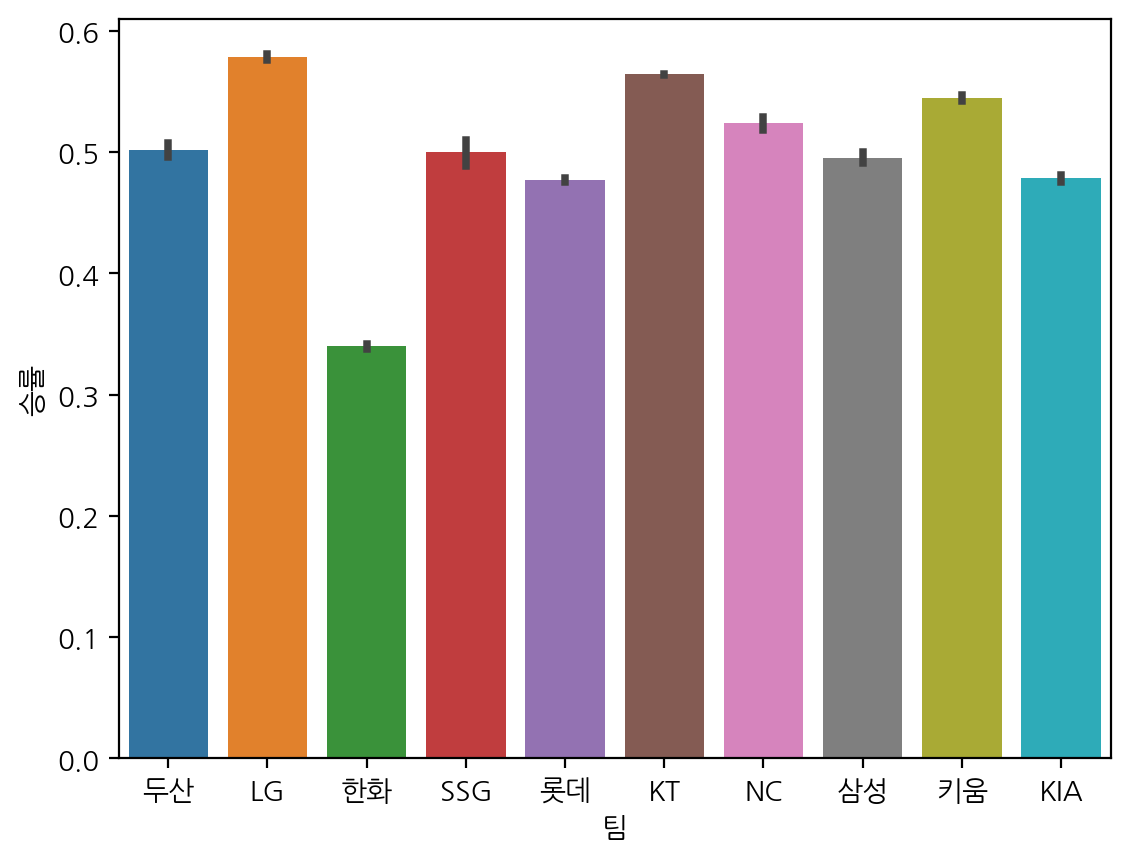

In [84]:
# 2020~2022년 팀별 승률
sns.barplot(x='팀', y='승률', data=train);

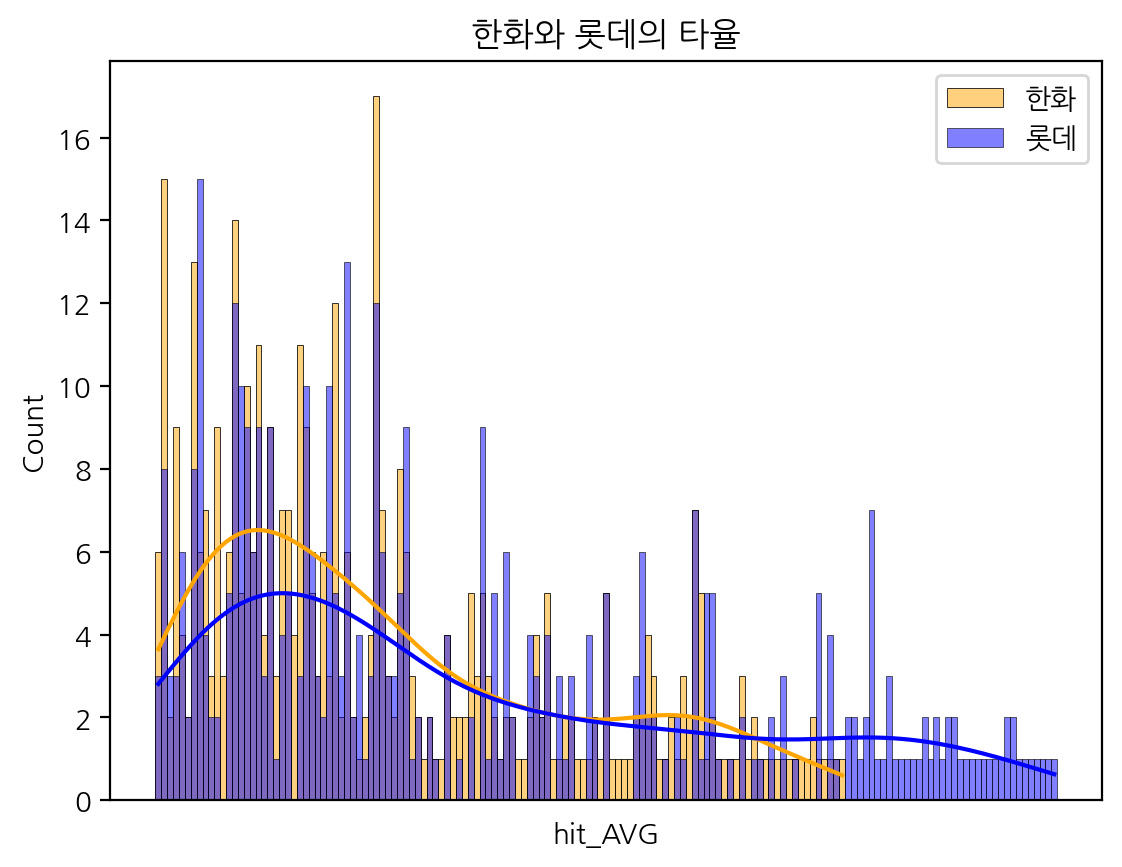

In [85]:
# 한화와 롯데의 타율을 비교해봤는데
# 한화는 타율이 낮은쪽에 몰려있고 롯데는 타율이 높은쪽에 몰려있다
# 역시 롯데는 불망이고 한화는 솜방망이가 맞았다.

plt.title("한화와 롯데의 타율")
hanhwa = train[train['팀'] == '한화']
lotte = train[train['팀'] == '롯데']
sns.histplot(data=hanhwa, x='hit_AVG', kde=True, color='orange', alpha=0.5, label='한화')
sns.histplot(data=lotte, x='hit_AVG', kde=True, color='blue', alpha=0.5, label='롯데')
plt.legend()
plt.xticks([]);

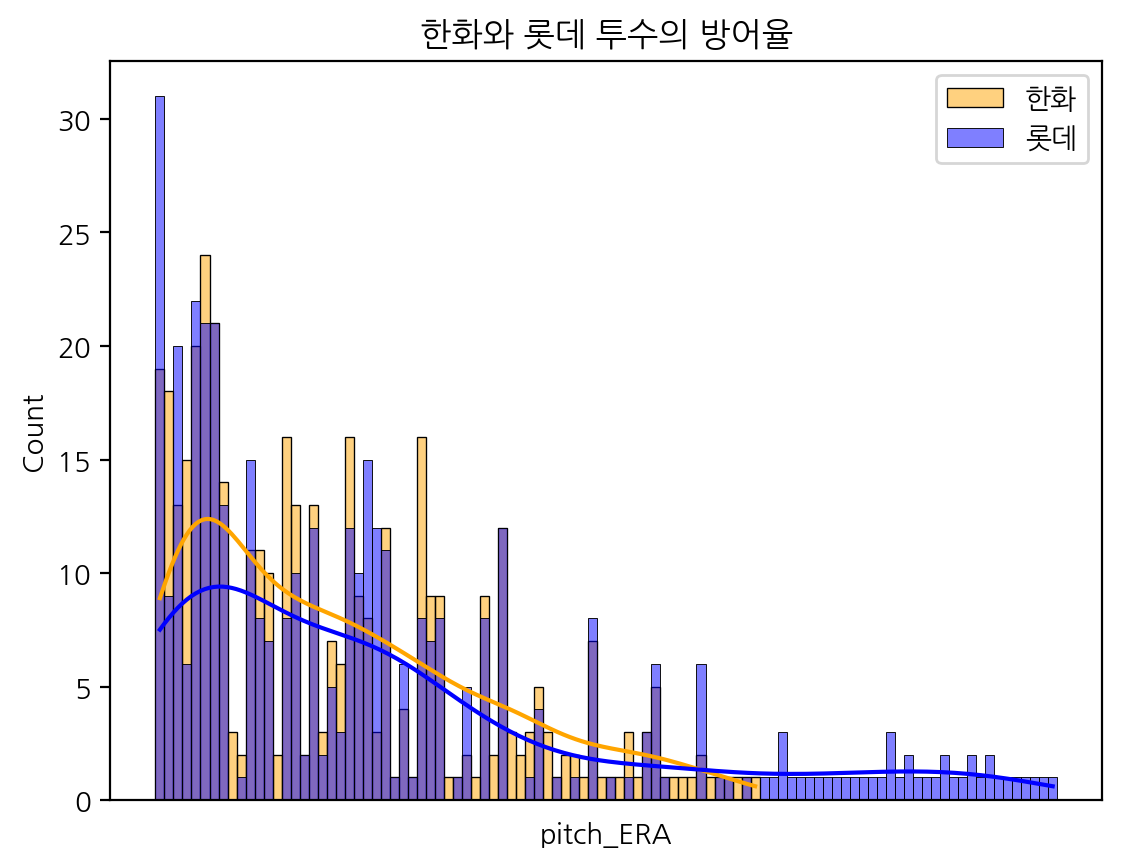

In [86]:
# 투수는 한화 투수쪽이 더 강한걸 볼 수 있다
# 방어율이 낮을수로 좋음

plt.title("한화와 롯데 투수의 방어율")
hanhwa = train[train['팀'] == '한화']
lotte = train[train['팀'] == '롯데']
sns.histplot(data=hanhwa, x='pitch_ERA', kde=True, color='orange', alpha=0.5, label='한화')
sns.histplot(data=lotte, x='pitch_ERA', kde=True, color='blue', alpha=0.5, label='롯데')
plt.legend()
plt.xticks([]);

## 이상치가 있는 컬럼 log변환

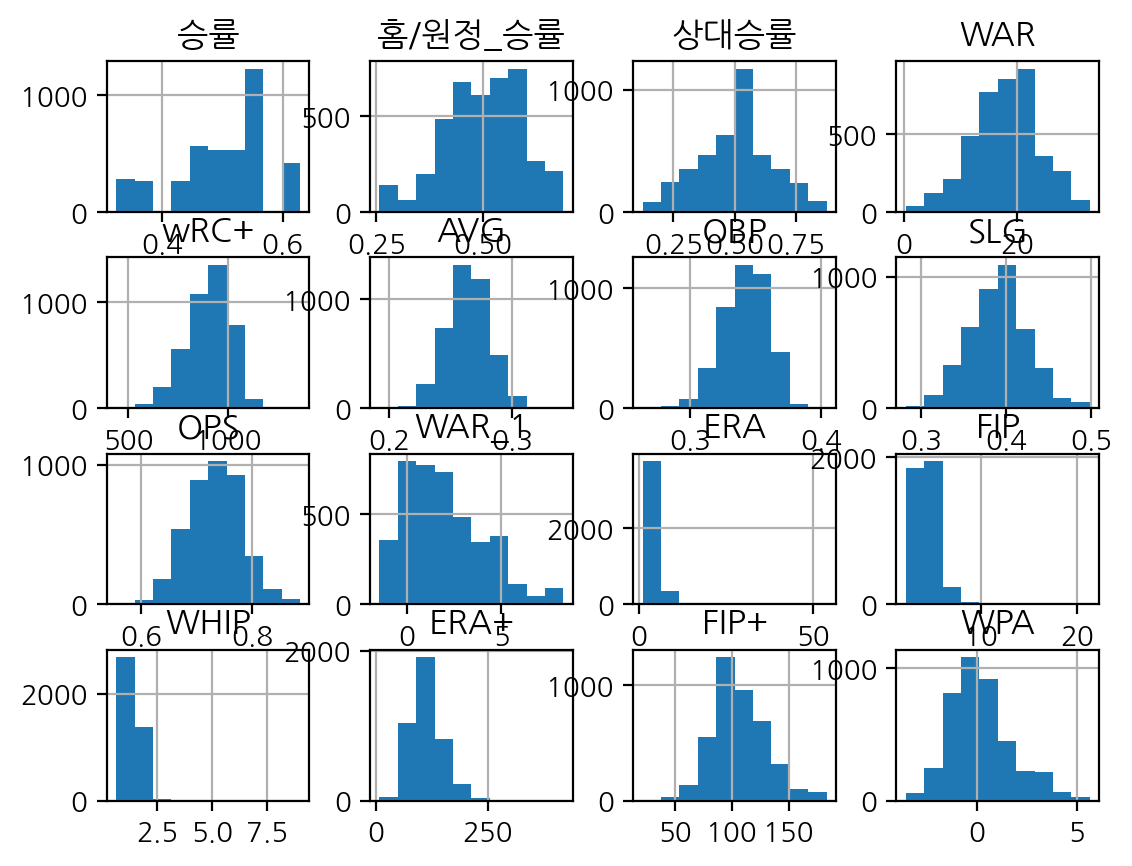

In [87]:
train[['승률', '홈/원정_승률', '상대승률','WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS',
           'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']].hist();

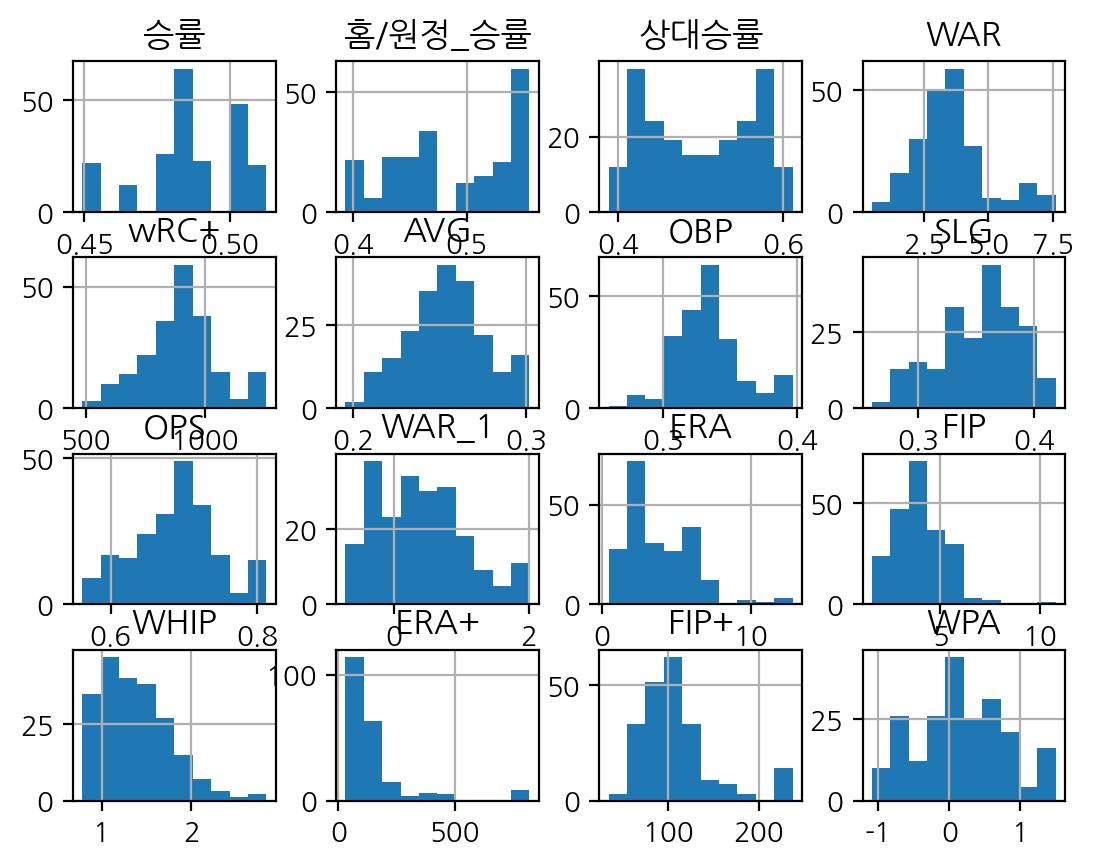

In [88]:
valid[['승률', '홈/원정_승률', '상대승률','WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS',
           'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']].hist();

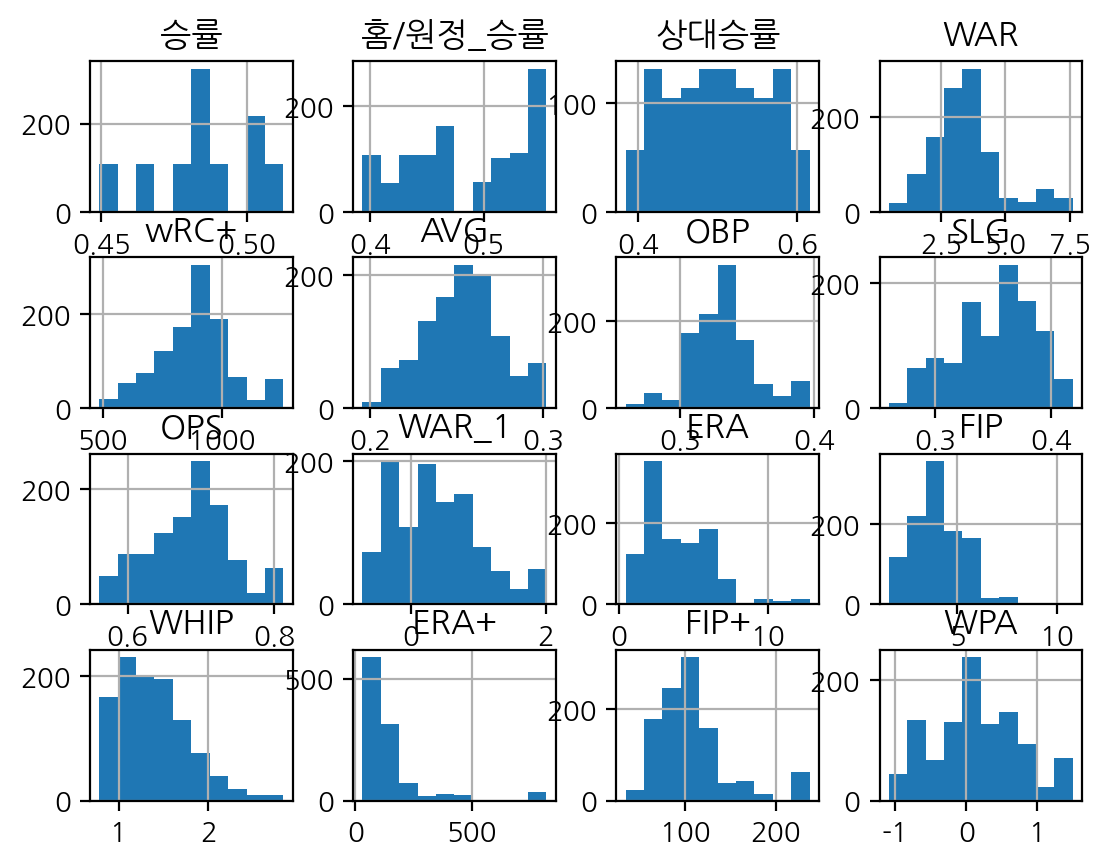

In [89]:
test[['승률', '홈/원정_승률', '상대승률','WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS',
           'WAR_1', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA']].hist();

In [90]:
# 이미 팀/선수 데이터처리에서 한번 정제된 데이터이고, 각 지표들은 실제 선수들의 지표를 나타내기 때문에
# 최대한 기존의 데이터에서 건드리지 않기위해 ERA, FIP, WHIP, ERA+만 선택함
# 이상치를 없애거나 대체하는 방식으로 처리하는 것보다는 log변환이 가장 적합한다고 판단함

train['ERA_log'] = np.log(train['ERA'] + 1)
train['FIP_log'] = np.log(train['FIP'] + 1)
train['WHIP_log'] = np.log(train['WHIP'] + 1)
train['ERA+_log'] = np.log(train['ERA+'] + 1)

valid['ERA_log'] = np.log(valid['ERA'] + 1)
valid['FIP_log'] = np.log(valid['FIP'] + 1)
valid['WHIP_log'] = np.log(valid['WHIP'] + 1)
valid['ERA+_log'] = np.log(valid['ERA+'] + 1)

test['ERA_log'] = np.log(test['ERA'] + 1)
test['FIP_log'] = np.log(test['FIP'] + 1)
test['WHIP_log'] = np.log(test['WHIP'] + 1)
test['ERA+_log'] = np.log(test['ERA+'] + 1)

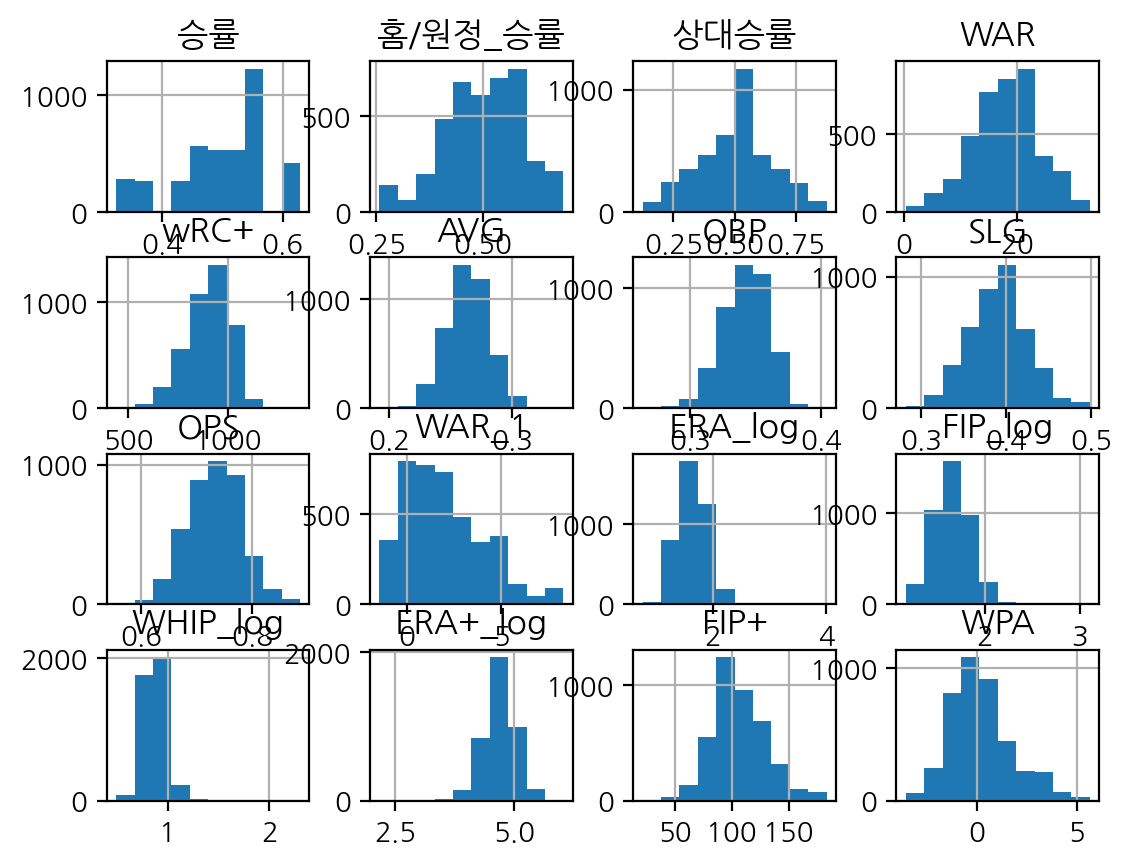

In [91]:
train[['승률', '홈/원정_승률', '상대승률','WAR', 'wRC+', 'AVG', 'OBP', 'SLG', 'OPS',
           'WAR_1', 'ERA_log', 'FIP_log', 'WHIP_log', 'ERA+_log', 'FIP+', 'WPA']].hist();

# 데이터셋 나누기

In [92]:
train.columns

Index(['날짜', '구장', '팀', 'hit_TPA', 'hit_AB', 'hit_R', 'hit_H', 'hit_HR',
       'hit_RBI', 'hit_BB', 'hit_HBP', 'hit_SO', 'hit_GO', 'hit_FO', 'hit_PIT',
       'hit_GDP', 'hit_LOB', 'hit_AVG', 'hit_OPS', 'hit_LI', 'hit_WPA',
       'hit_RE24', 'pitch_IP', 'pitch_TBF', 'pitch_H', 'pitch_R', 'pitch_ER',
       'pitch_BB', 'pitch_HBP', 'pitch_K', 'pitch_HR', 'pitch_GO-FO',
       'pitch_PIT-S', 'pitch_IR-IS', 'pitch_GSC', 'pitch_ERA', 'pitch_WHIP',
       'pitch_LI', 'pitch_WPA', 'pitch_RE24', 'def_IP', 'def_PO', 'def_A',
       'def_E', 'def__P', 'def__A', 'def_GDP', '구분', '승률', '홈/원정_승률', '상대승률',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '선발투수', 'score', 'WAR',
       'wRC+', 'AVG', 'OBP', 'SLG', 'OPS', 'WAR_1', 'ERA', 'FIP', 'WHIP',
       'ERA+', 'FIP+', 'WPA', 'ERA_log', 'FIP_log', 'WHIP_log', 'ERA+_log'],
      dtype='object')

In [93]:
# VIF계수와 feature 중요도를 확인하고 확인한 후 feature를 선별함

feature = ['승률', '홈/원정_승률', '상대승률','WAR', 'wRC+', 'AVG', 'OBP', 'OPS',
           'WAR_1', 'ERA_log', 'WHIP_log', 'FIP+', 'WPA']
target = ['score']

X_train = train[feature]
y_train = train[target]

X_valid = valid[feature]
y_valid = valid[target]

X_test = test[feature]

In [94]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((4105, 13), (4105, 1), (216, 13), (216, 1), (1080, 13))

## 다중공선성 확인

In [95]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X_train)
vif = pd.DataFrame({'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]}, index=X.columns)
vif

,VIF
const,1024.981773
승률,5.522410
홈/원정_승률,4.132215
상대승률,1.402355
WAR,5.905999
wRC+,10.475054
AVG,5.131490
OBP,5.697796
OPS,10.450853
WAR_1,8.039042


In [96]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# xgboost 모델 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 하이퍼파라미터 설정
params = {'n_estimators': [10, 50, 100, 200],
          'max_depth': [3, 6, 10],
          'learning_rate': [0.01, 0.05, 0.1],
          'colsample_bytree': [0.5, 0.7, 1.0],
          'subsample': [0.5, 0.7, 1.0],
          'gamma': [0, 0.1, 0.5]}

# 그리드서치를 사용하여 최적의 하이퍼파라미터 탐색
search = GridSearchCV(xgb_model, param_grid=params, cv=5, n_jobs=-1)
search.fit(X_train, y_train)

# 최적의 하이퍼파라미터로 모델 재학습
xgb_model = xgb.XGBRegressor(**search.best_params_, random_state=42)
xgb_model.fit(X_train, y_train)

# 검증셋 예측
y_pred = xgb_model.predict(X_valid)

# 검증셋 평가
score = r2_score(y_valid, y_pred)

In [97]:
y_test = xgb_model.predict(X_test)
y_test

array([-1.2063009 ,  0.5712713 , -1.0879643 , ...,  0.71780294,
       -2.0074525 ,  0.60659796], dtype=float32)

## feature importance 확인

In [98]:
importance = xgb_model.feature_importances_
feature_names = X_train.columns

for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")

승률: 0.0292
홈/원정_승률: 0.0490
상대승률: 0.1901
WAR: 0.0580
wRC+: 0.0552
AVG: 0.0492
OBP: 0.0768
OPS: 0.0591
WAR_1: 0.0859
ERA_log: 0.1397
WHIP_log: 0.0621
FIP+: 0.0443
WPA: 0.1015


In [99]:
# 예측 결과를 데이터프레임으로 변환
df_y_test = pd.DataFrame({'score': y_test})
df_y_test

,score
0,-1.206301
1,0.571271
2,-1.087964
3,-0.596089
4,-0.184453
...,...
1075,0.215028
1076,-0.503511
1077,0.717803
1078,-2.007452


In [100]:
# 날짜,팀,구장 정보를 포함한 score
test_result = pd.concat([test[['날짜', '팀', '구장']].reset_index(drop=True), df_y_test], axis=1)
test_result

,날짜,팀,구장,score
0,2023-05-02,한화,잠실,-1.206301
1,2023-05-02,두산,잠실,0.571271
2,2023-05-02,KT,인천SSG랜더스,-1.087964
3,2023-05-02,SSG,인천SSG랜더스,-0.596089
4,2023-05-02,키움,라이온즈파크,-0.184453
...,...,...,...,...
1075,2023-09-10,KT,케이티위즈파크,0.215028
1076,2023-09-10,LG,챔피언스필드,-0.503511
1077,2023-09-10,KIA,챔피언스필드,0.717803
1078,2023-09-10,한화,고척돔,-2.007452


In [101]:
# 2행씩 돌아가면서, 위와 아래행의 score를 비교한다.
# 아래에서 위로 score 값을 뺀다. 양수면 '패','승' / 음수면 '승','패' 를 넣어준다
# 스코어의 차이의 절대값이 0.05이하면 '무' 를 넣어준다.

test_result['결과'] = ''
for i in range(0, len(test_result), 2):
    score_diff = abs(test_result.iloc[i+1]['score'] - test_result.iloc[i]['score'])
    if score_diff > 0.05:
        if test_result.iloc[i+1]['score'] - test_result.iloc[i]['score'] > 0:
            test_result.at[i, '결과'] = '패'
            test_result.at[i+1, '결과'] = '승'
        else:
            test_result.at[i, '결과'] = '승'
            test_result.at[i+1, '결과'] = '패'
    else:
        test_result.at[i, '결과'] = '무'
        test_result.at[i+1, '결과'] = '무'

test_result['결과'].value_counts()

패    529
승    529
무     22
Name: 결과, dtype: int64

In [102]:
# 한해에 무승부는 평균 10~20회정도 발생한다.
# 무승부인 경기(score 차이가 0.05 이하)

draw = test_result[test_result['결과'] == '무'][['날짜', '팀', '구장', '결과']]
draw

,날짜,팀,구장,결과
76,2023-05-10,SSG,챔피언스필드,무
77,2023-05-10,KIA,챔피언스필드,무
92,2023-05-12,한화,인천SSG랜더스,무
93,2023-05-12,SSG,인천SSG랜더스,무
156,2023-05-19,두산,케이티위즈파크,무
157,2023-05-19,KT,케이티위즈파크,무
232,2023-05-28,KT,라이온즈파크,무
233,2023-05-28,삼성,라이온즈파크,무
572,2023-07-07,LG,부산사직,무
573,2023-07-07,롯데,부산사직,무


In [103]:
real_result = test_result[['날짜', '팀', '구장', '결과']]
real_result

,날짜,팀,구장,결과
0,2023-05-02,한화,잠실,패
1,2023-05-02,두산,잠실,승
2,2023-05-02,KT,인천SSG랜더스,패
3,2023-05-02,SSG,인천SSG랜더스,승
4,2023-05-02,키움,라이온즈파크,승
...,...,...,...,...
1075,2023-09-10,KT,케이티위즈파크,승
1076,2023-09-10,LG,챔피언스필드,패
1077,2023-09-10,KIA,챔피언스필드,승
1078,2023-09-10,한화,고척돔,패


In [104]:
real_result.head(50)

,날짜,팀,구장,결과
0,2023-05-02,한화,잠실,패
1,2023-05-02,두산,잠실,승
2,2023-05-02,KT,인천SSG랜더스,패
3,2023-05-02,SSG,인천SSG랜더스,승
4,2023-05-02,키움,라이온즈파크,승
5,2023-05-02,삼성,라이온즈파크,패
6,2023-05-02,LG,창원NC파크,패
7,2023-05-02,NC,창원NC파크,승
8,2023-05-02,롯데,챔피언스필드,패
9,2023-05-02,KIA,챔피언스필드,승


In [105]:
# 5월부터 마지막 경기까지 승,무,패 예측

a = real_result.groupby(['팀', '결과']).size().unstack(fill_value=0)
a = a[['승', '무', '패']]
a = a.sort_values(by='승', ascending=False)
a

결과,승,무,패
팀,,,
키움,74,1,33
KIA,69,3,36
NC,66,1,41
LG,65,1,42
SSG,63,6,39
KT,60,3,45
두산,57,1,50
삼성,35,3,70
롯데,25,1,82
